## Introduction

#### Business Problem

**Dataset:** Subscription data from a marketing campaign conducted by a banking institution.

**Problem Statement:** The business problem is a binary classification challenge. The goal of the classification is to predict whether a client contacted through the marketing campaign will subscribe to a term deposit.

**Workflow**

- Exploratory Data Analysis (EDA)
- Preprocessing (including dimensionality reduction and feature engineering)
- Identification of Most Important Features
- Model Development (including hyperparameter tuning and boosting)
- Model Evaluation
- End-to-End Process Deployment 😊

In [62]:
import numpy as np
import re
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


from imblearn.over_sampling import SMOTE
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss, roc_auc_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

file_path = '/file/path/to/your/file/'
file_name = '/your/file/name.csv'
target = 'your_target'

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Input variables:

**Bank client data:**

1. **age**: (numeric)
2. **job**: type of job (categorical)
3. **marital status**: (categorical)
4. **education**: (categorical)
5. **default**: has credit in default? (categorical)
6. **housing**: has a housing loan? (categorical)
7. **loan**: has a personal loan? (categorical)

**Related to the last contact of the current campaign:**

8. **contact**: contact communication type (categorical)
9. **month**: last contact month of the year (categorical)
10. **day of week**: last contact day of the week (categorical)
11. **duration**: last contact duration in seconds (numeric)

****Other attributes:**

12. **campaign**: number of contacts performed during this campaign for this client (numeric; includes last contact)
13. **pdays**: number of days since the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. **previous**: number of contacts performed before this campaign for this client (numeric)
15. **poutcome**: outcome of the previous marketing campaign (categorical)

**Social and economic context attributes:**

16. **employment variation rate**: quarterly indicator (numeric)
17. **consumer price index**: monthly indicator (numeric)
18. **consumer confidence index**: monthly indicator (numeric)
19. **euribor 3 month rate**: daily indicator (numeric)
20. **number of employees**: quarterly indicator (numeric)

**Output variable (target):**

21. **y**: has the client subscribed to a term deposit? (binary)

**Key feature from initial observations**

**duration (feature 11):** "this represents the length of the last contact in seconds (numeric)."

**Why is duration important?**

- **direct impact:** the length of the last call is a strong indicator of whether a client will subscribe to the term deposit. generally, longer conversations often reflect more client interest.
- **empirical insight:** a duration of zero usually signals a lack of client interest, leading to a higher likelihood of a "no" outcome.
- **benchmark usage:** while in real-world scenarios, the duration shouldn't be used in the model, it acts as a powerful benchmark predictor, highlighting its significance despite potential biases.

**Other key features to watch:**

although duration is the most influential feature, there are others that also play an important role:
- **previous campaign outcome (feature 15: poutcome):** the result of past campaigns can provide insights into a client's likelihood of subscribing.
- **number of contacts (feature 12: campaign):** repeated contact with the client may influence their decision-making.
- **employment variation rate (feature 16: emp.var.rate):** changes in employment rates can affect decisions about financial investments like term deposits.
- **euribor 3 month rate (feature 19: euribor3m):** fluctuating interest rates can make term deposits more or less attractive.
while duration stands out as a key predictor, especially for benchmark purposes, if it’s excluded, consider focusing on the combined influence of **poutcome**, **emp.var.rate**, and **campaign** for predictive analysis.
**note:** duration has a significant influence on the target variable (e.g., if the duration is zero, the likely outcome is "no"). however, since this value isn’t known before a call, duration should only be used for benchmark purposes and omitted from actual predictive modeling.


**The provided code defines two functions: load_and_clean_csv, which loads a CSV file into a DataFrame, cleans the column names and values by removing special characters and converting them to lowercase, and summarize_and_unique_values, which prints summary information of the DataFrame and returns unique values for each column, excluding a specified target column. The code then loads and cleans a CSV file using the first function and summarizes it while extracting unique values from the DataFrame using the second function. This workflow facilitates data preprocessing and provides insights into the dataset's structure and content.**

In [63]:
def load_and_clean_csv(file_path: str, file_name: str) -> pd.DataFrame:
    """
    Load a CSV file into a DataFrame and clean column names and values by removing special characters
    and converting them to lowercase.
    Parameters:
    - file_path (str): Path to the directory containing the file.
    - file_name (str): The name of the CSV file to load.
    Returns:
    - DataFrame: Cleaned DataFrame with special characters removed from column names and values, and all text in lowercase.
    """
    # Load CSV file
    df = pd.read_csv(f"{file_path}{file_name}", sep=';', encoding='utf-8')
    # Define the regex pattern for special characters
    pattern = r'[^a-zA-Z0-9\s]'
    # Clean and convert column names to lowercase
    df.columns = [re.sub(pattern, '', col).strip().lower() for col in df.columns]
    # Clean object type column values and convert to lowercase
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].apply(lambda x: re.sub(pattern, '', str(x)).strip().lower())
    return df
def summarize_and_unique_values(df: pd.DataFrame, target: str) -> dict:
    """
    Print summary information of the DataFrame and return unique values per column, excluding the target column.
    Parameters:
    - df (DataFrame): The input DataFrame to summarize and extract unique values.
    - target (str): The target column to exclude from unique value extraction.
    Returns:
    - dict: A dictionary containing unique values for each column excluding the target column.
    """
    # Print DataFrame summary information
    print(df.info())
    print(f"\nThe sum of null values per column:\n{df.isnull().sum()}")
    # Return unique values for each column, excluding the target column
    return {col: df[col].unique().tolist() for col in df.columns if col != target}
# Load and clean the CSV file
df = load_and_clean_csv(file_path, file_name)
# Summarize the DataFrame and get unique values (excluding the target column)
unique_values = summarize_and_unique_values(df, target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           41188 non-null  int64  
 1   job           41188 non-null  object 
 2   marital       41188 non-null  object 
 3   education     41188 non-null  object 
 4   default       41188 non-null  object 
 5   housing       41188 non-null  object 
 6   loan          41188 non-null  object 
 7   contact       41188 non-null  object 
 8   month         41188 non-null  object 
 9   dayofweek     41188 non-null  object 
 10  duration      41188 non-null  int64  
 11  campaign      41188 non-null  int64  
 12  pdays         41188 non-null  int64  
 13  previous      41188 non-null  int64  
 14  poutcome      41188 non-null  object 
 15  empvarrate    41188 non-null  float64
 16  conspriceidx  41188 non-null  float64
 17  consconfidx   41188 non-null  float64
 18  euribor3m     41188 non-nu

**Printing unique values for an initial overview can help identify potential preprocessing needs.**

In [92]:
# Print unique values for inspection
print(f"\nUnique values per column (excluding '{target}'):")
for column, values in unique_values.items():
    print(f"{column}: {values}")


Unique values per column (excluding 'y'):
age: [56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55, 49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36, 28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95, 77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81, 74, 17, 87, 91, 86, 98, 94, 84, 92, 89]
job: ['other', 'technical', 'office', 'busyness', 'unknown']
marital: ['married', 'single', 'divorced', 'unknown']
education: ['basic4y', 'highschool', 'basic6y', 'basic9y', 'professionalcourse', 'unknown', 'universitydegree', 'illiterate']
default: ['no', 'unknown', 'yes']
housing: ['no', 'yes', 'unknown']
loan: ['no', 'yes', 'unknown']
contact: ['telephone', 'cellular']
month: ['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr', 'sep']
dayofweek: ['mon', 'tue', 'wed', 'thu', 'fri']
duration: [261, 149, 226, 151, 307, 198, 139, 217, 380, 50, 55, 222, 137, 293, 146, 174, 312, 440, 353, 195, 38, 262, 342, 181, 172, 99, 93

**Observation:**
After an initial overview of the unique values in the data, several potential issues are evident from a modeling perspective, where preprocessing and feature engineering are recommended.

- **job**: there are too many categories in this feature. recategorization will reduce the number of unique values, positively impacting computation.
- **age**: categorizing age into groups such as 'young', 'prime', and 'old' could improve model performance by providing clearer distinctions in age ranges.
- **pdays**: the value 999 is a significant outlier and should be processed (it will likely be replaced with -1).
- **campaign**: similar to age, categorizing the campaign feature could be beneficial.
- **duration**: this feature also requires categorization.
- **education**: similar to the job feature, categories such as 'basic4y', 'highschool', 'basic6y', and 'basic9y' can be grouped into a 'basic' category.

**For categorical values, there are numerous distinct entries that could benefit from advanced categorization, such as 'basic4y', 'highschool', 'basic6y', and 'basic9y', which can be grouped under a single category labeled 'basic' education. This approach simplifies the dataset by reducing complexity and enhancing interpretability. Implementing such categorization can improve the effectiveness of subsequent analyses and modeling efforts. But first, lets performe global analysis**

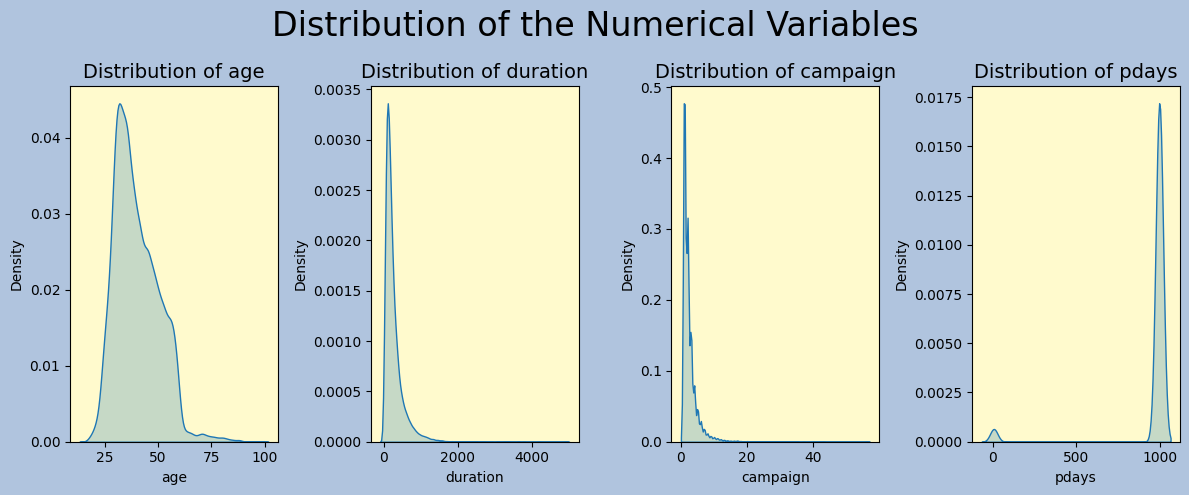

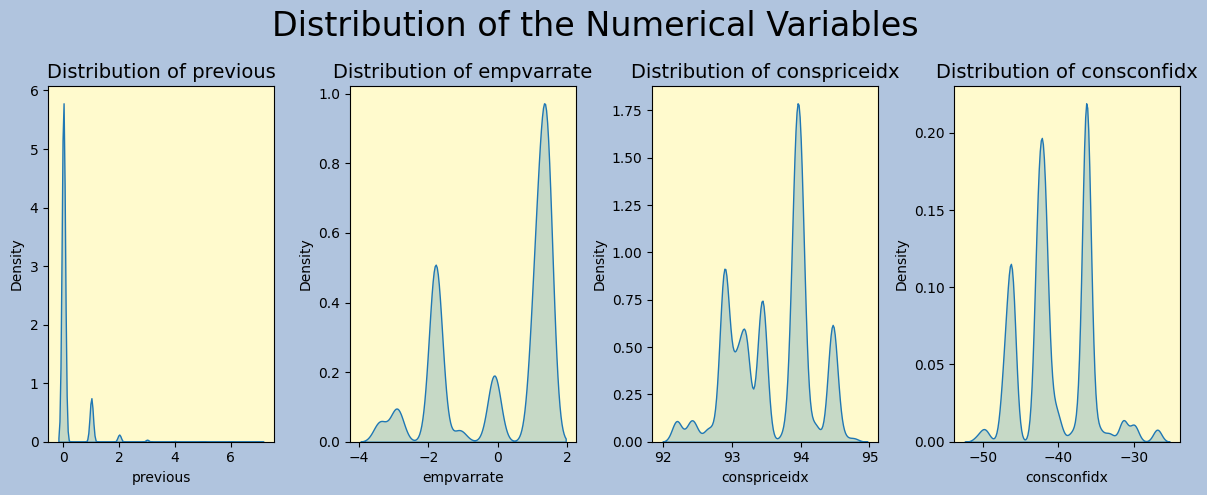

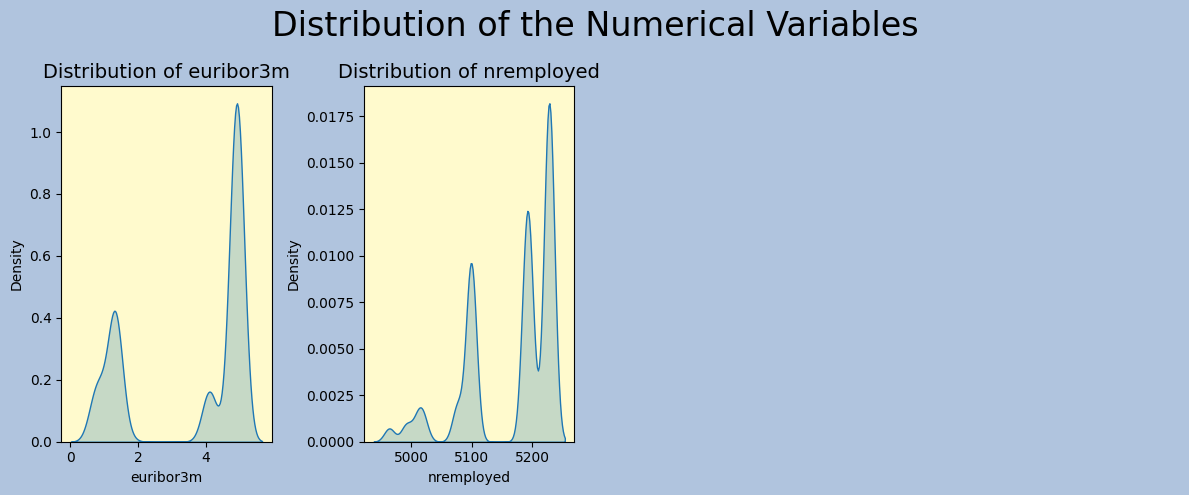

In [4]:
def plot_distributions(df):
    """
    Plots distributions for numerical variables in the dataset.
    Parameters:
    data : pandas DataFrame
        The input data containing the features.
    """
    # Get the numerical-type columns
    numerical_features = df.select_dtypes(include=['number']).columns.tolist()
    # Calculate the number of columns and how many rows of plots will be needed
    n_cols = len(numerical_features)
    n_rows = (n_cols + 3) // 4  # 4 plots per row
    for i in range(n_rows):
        fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12, 5))
        for j in range(4):
            index = i * 4 + j
            if index < n_cols:
                ax = axes[j]  # Get the corresponding axis
                # Using sns.kdeplot for smooth distribution
                sns.kdeplot(df[numerical_features[index]], ax=ax, fill=True)
                ax.set_title('Distribution of ' + str(numerical_features[index]), fontsize=14)
                ax.set_facecolor('lemonchiffon')
            else:
                axes[j].axis('off')  # Hide any unused axes
        fig.suptitle("Distribution of the Numerical Variables", fontsize=24)
        plt.tight_layout()
        fig.set_facecolor('lightsteelblue')
        plt.show()  
plot_distributions(df)

**Observation:**
- **age**: the majority of clients are aged 30–40, with fewer clients in older age groups. the distribution is right-skewed, indicating a smaller proportion of older clients.
- **duration**: most calls were short, with very few long calls. the data is heavily skewed toward shorter durations.
- **campaign**: clients were typically contacted once or twice during the campaign. very few clients received multiple contacts.
- **pdays**: the value 999 dominates the distribution, showing that most clients had no previous contact. few other values are present, indicating sparse prior contact information.
- **previous**: most clients had no or very few previous contacts. the distribution is heavily skewed toward zero previous interactions.
- **employment variation rate (empvarrate)**: multiple peaks in the employment variation rate indicate fluctuations, reflecting different economic conditions.
- **consumer price index (conspriceidx)**: there are clear peaks in the consumer price index, showing distinct economic periods rather than a continuous trend.
- **consumer confidence index (consconfidx)**: the distribution shows multiple peaks, suggesting specific economic conditions and fluctuations in consumer confidence.
- **euribor 3-month rate**: most data points cluster around the 4% mark, with fewer observations at lower rates.
- **number of employees (nremployed)**: employment numbers are mostly concentrated around 5100–5200, showing stability in the workforce.

### Overall conclusions:
- **age**: concentration of clients in the 30–40 age range, with fewer older clients.
- **duration**: calls are predominantly short in length.
- **campaign**: most clients were contacted once or twice, indicating low contact frequency.
- **previous contacts**: very few clients had previous interactions with the campaign.
- **economic indicators**: fluctuations are evident in employment rates, consumer price index, and consumer confidence index.
- **stable features**: euribor rates and employment numbers show stability across the dataset.

This overview suggests that the data will need preprocessing steps like handling skewness, outliers, and potentially converting some numerical variables into categorical or grouped values for better model performance.

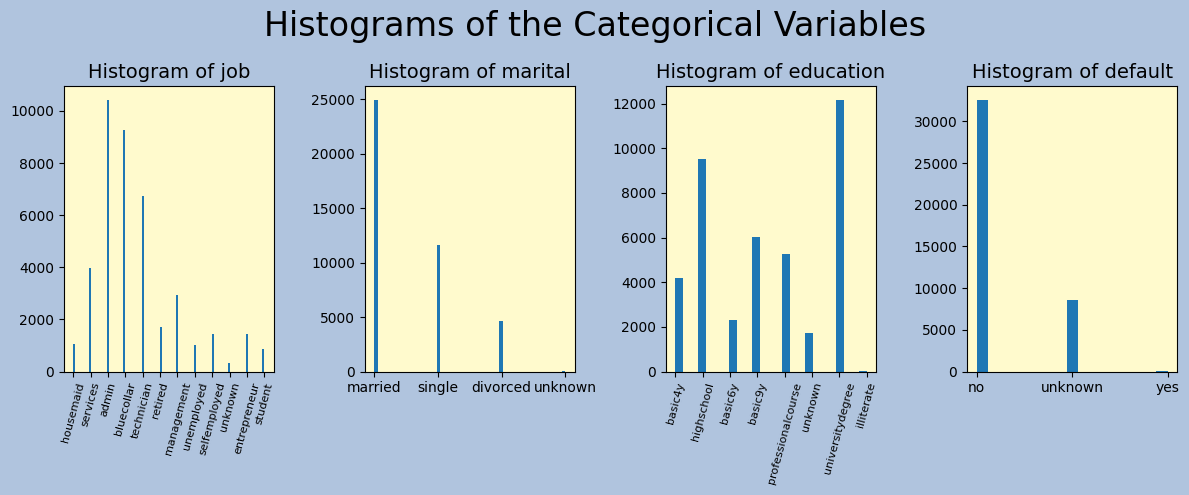

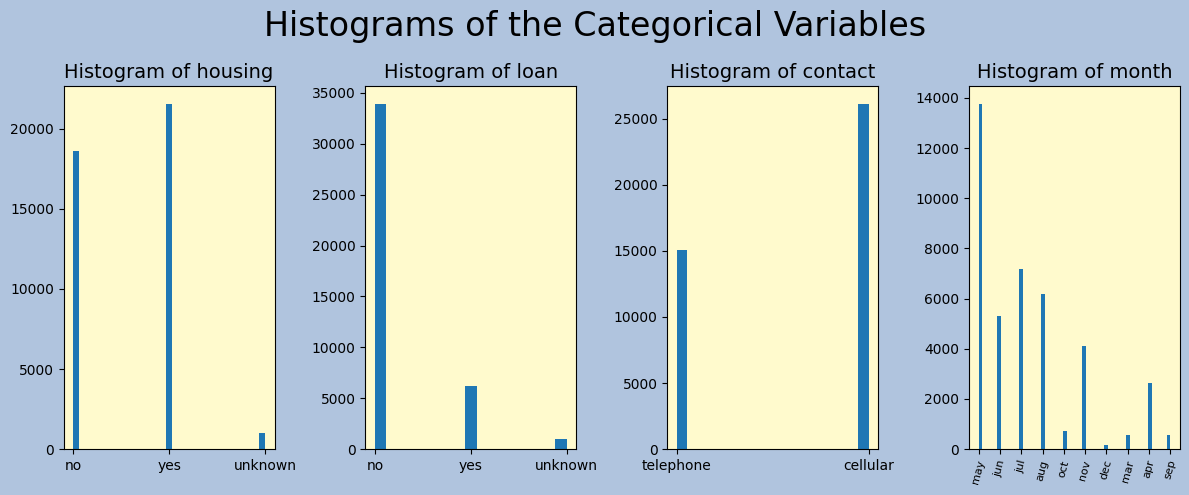

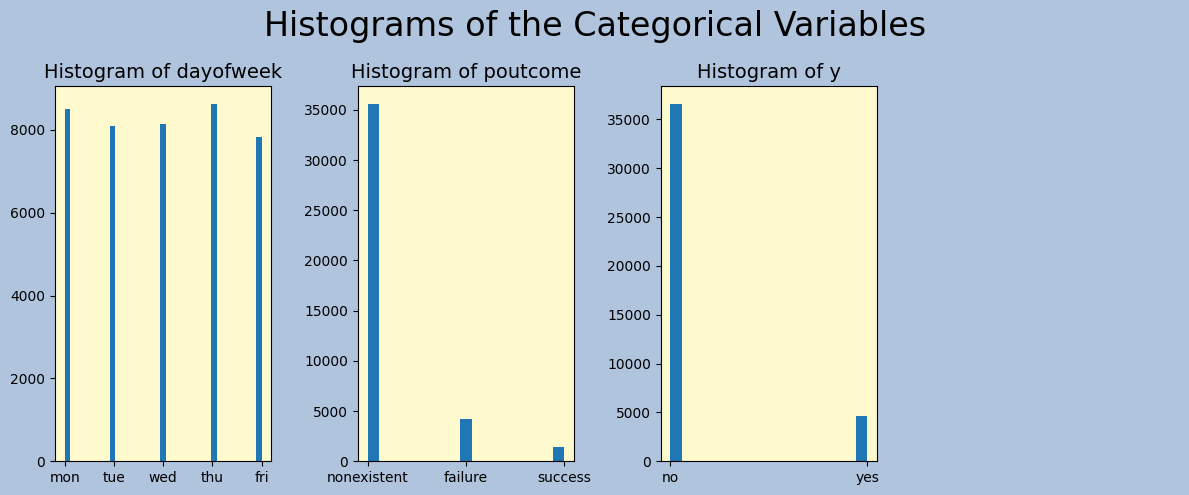

In [ ]:
def plot_histograms(df):
    """
    Plots histograms for categorical variables in the dataset.
    Parameters:
    data : pandas DataFrame
        The input data containing the features.
    """
    # Get the object-type columns
    object_features = df.select_dtypes(include=['object']).columns.tolist()
    # Calculate the number of columns and how many rows of plots will be needed
    n_cols = len(object_features)
    n_rows = (n_cols + 3) // 4  # 4 plots per row
    for i in range(n_rows):
        fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12, 5))
        for j in range(4):
            index = i * 4 + j
            if index < n_cols:
                ax = axes[j]  # Get the corresponding axis
                ax.hist(df[object_features[index]], bins='auto')  # Automatically determine bins
                ax.set_title('Histogram of ' + str(object_features[index]), fontsize=14)
                ax.set_facecolor('lemonchiffon')
                # Adjust x-tick labels if there are more than 5 unique values
                if df[object_features[index]].nunique() > 5:
                    ticks = ax.get_xticks()  # Get the current ticks
                    ax.set_xticks(ticks)  # Set ticks explicitly
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=75, fontsize=8)
            else:
                axes[j].axis('off')  # Hide any unused axes
        fig.suptitle("Histograms of the Categorical Variables", fontsize=24)
        plt.tight_layout()
        fig.set_facecolor('lightsteelblue')
        plt.show()
plot_histograms(df)

- **Job**: Majority in "bluecollar" and "management" roles, followed by "technicians" and "admin" Few "students" "unemployed" or "entrepreneurs"
- **Marital Status**: Mostly "married" then "single". Few "divorced" and almost no "unknown".
- **Education**: Dominated by "secondary" and "tertiary" education. Fewer with "primary" and "unknown" levels.
- **Default**: Most clients have no credit default. "unknown" category is larger than "yes".
- **Housing Loan**: Majority either have or don't have a housing loan; very few "unknown".
- **Personal Loan**: Most do not have a personal loan, with minimal "unknown".
- **Contact Type**: Predominantly via "cellular," fewer via "telephone".
- **Month**: Most contacts in May, followed by August and July. Fewer in March, September, and December.
- **Day of the Week**: Even distribution across weekdays.
- **Poutcome**: Most are "nonexistent" from previous campaigns, with "failure" being second and "success" rare.
- **Target Variable (y)**: Most clients did not subscribe to a term deposit, with few who did.

### Overall Conclusions:
- **Job**: Dominated by blue-collar and managerial roles.
- **Marital/Education**: Mostly married, with secondary/tertiary education.
- **Loans**: Few personal loans or credit defaults.
- **Contact**: Mostly via mobile phones, often in May, evenly spread across weekdays.
- **Campaign**: Most previous campaigns were unsuccessful, and few clients subscribed to the term deposit.

**The DataPreprocessor class is created to help transform and categorize various features in a DataFrame, making it easier to analyze the data. It offers methods to categorize aspects like age, job, duration, education, and campaign engagement, along with processing the 'pdays' column and converting month and day values into numeric formats. The categories are hardcoded, so it is possible thet modification will be needed**


In [64]:
# Separate coding for y cuz after simple coding yes:0 no:1 but must vise-versa
class DataPreprocessor:
    def __init__(self, df):
        """Initialize with the DataFrame to be processed."""
        self.df = df
    def categorize_age(self, age):
        """Categorize age into groups."""
        if age < 30:
            return 'young'
        elif 30 <= age < 65:
            return 'prime'
        else:
            return 'veteran'
    def categorize_job(self, job):
        """Categorize job into groups."""
        job_categories = {
            'admin': 'office', 'management': 'office',
            'technician': 'technical', 'services': 'technical', 'bluecollar': 'technical',
            'entrepreneur': 'busyness', 'selfemployed': 'busyness',
            'unknown': 'unknown'
        }
        return job_categories.get(job, 'other')
    def categorize_duration(self, duration):
        """Categorize duration into predefined categories."""
        if duration < 31:
            return 'very Short'
        elif 31 <= duration < 61:
            return 'short'
        elif 61 <= duration < 181:
            return 'medium'
        elif 181 <= duration < 601:
            return 'long'
        else:
            return 'very_long'
    def process_pdays(self, column_name):
        """Process 'pdays' column and create a previous_contact binary column."""
        self.df[column_name] = self.df[column_name].replace(999, -1)
        self.df['previous_contact'] = (self.df[column_name] != -1).astype(int)
    def categorize_education(self, education):
        if education in ['basic9y','basic6y','basic4y','highschool']:
            return 'basic'
        elif education in  ['universitydegree','professionalcourse']:
            return 'higher'
        elif education in ['unknown']:
            return 'unknown'
        else:
            return 'other'
    def categorize_campaign(self, campaign):
        """Categorize campaign engagement levels."""
        if campaign < 5:
            return 'low_engagement'
        elif 5 <= campaign < 15:
            return 'moderate_engagement'
        else:
            return 'high_engagement'
    def map_columns(self):
        """Map month and day columns to numeric values."""
        month_mapping = {month: index + 1 for index, month in enumerate(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])}
        day_mapping = {day: index for index, day in enumerate(['mon', 'tue', 'wed', 'thu', 'fri'])}
    def preprocess(self):
        """Run all preprocessing steps."""
        self.df['age_category'] = self.df['age'].apply(self.categorize_age)
        self.df['job'] = self.df['job'].apply(self.categorize_job)
        self.df['education_category'] = self.df['education'].apply(self.categorize_education)
        self.df['duration_category'] = self.df['duration'].apply(self.categorize_duration)
        self.process_pdays('pdays')
        self.df['campaign_category'] = self.df['campaign'].apply(self.categorize_campaign)
        self.map_columns()

        return self.df  # Return the modified DataFrame

preprocessor = DataPreprocessor(df)
df_processed = preprocessor.preprocess()

# Additional validation and unique values check
df_processed.head()
unique_values = summarize_and_unique_values(df_processed, target)
# Print unique values for inspection
print(f"\nUnique values per column (excluding '{target}'):")
for column, values in unique_values.items():
    print(f"{column}: {values}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 41188 non-null  int64  
 1   job                 41188 non-null  object 
 2   marital             41188 non-null  object 
 3   education           41188 non-null  object 
 4   default             41188 non-null  object 
 5   housing             41188 non-null  object 
 6   loan                41188 non-null  object 
 7   contact             41188 non-null  object 
 8   month               41188 non-null  object 
 9   dayofweek           41188 non-null  object 
 10  duration            41188 non-null  int64  
 11  campaign            41188 non-null  int64  
 12  pdays               41188 non-null  int64  
 13  previous            41188 non-null  int64  
 14  poutcome            41188 non-null  object 
 15  empvarrate          41188 non-null  float64
 16  cons

**Data Analysis performance: Extracting insights and Trends in the data**

*duration*

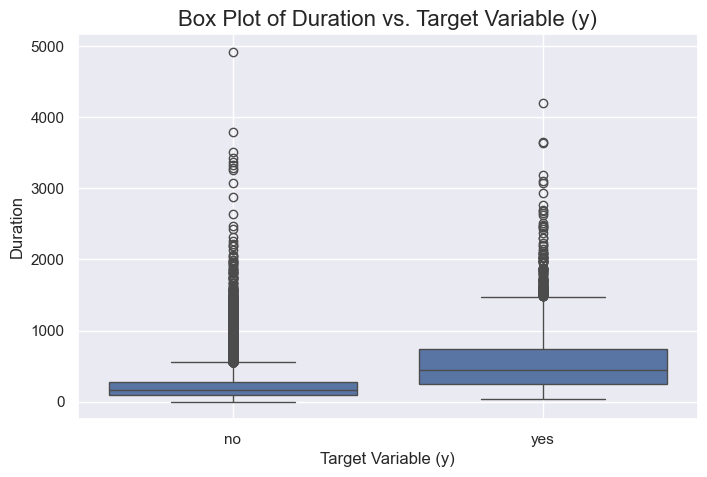

In [65]:
# Creating a box plot for 'duration' by target variable 'y'
plt.figure(figsize=(8, 5))  # Set figure size for better visibility
sns.boxplot(data=df_processed, x='y', y='duration')
plt.title('Box Plot of Duration vs. Target Variable (y)', fontsize=16)
plt.xlabel('Target Variable (y)', fontsize=12)
plt.ylabel('Duration', fontsize=12)
# Displaying the plot
plt.grid(True)  # Add grid for better readability
plt.show()

**Observation:**

The box plot reveals some outliers in the data, showing samples outside the range of statistical density. 
Additionally, there is a noticeable dependency: as the duration of contact with a client increases, the frequency of 'yes' decisions also rises. 
This suggests that longer contact durations may positively influence the likelihood of a favorable decision.

In [66]:
for x in range(95, 101 , 1):
    print("{}% of calls have duration less than equal to {}".format(x, df_processed.duration.quantile(x/100)))
iqr = df_processed.duration.quantile(0.75) - df_processed.duration.quantile(0.25)
print('IQR {}'.format(iqr))

95% of calls have duration less than equal to 752.6500000000015
96% of calls have duration less than equal to 820.5199999999968
97% of calls have duration less than equal to 911.0
98% of calls have duration less than equal to 1052.260000000002
99% of calls have duration less than equal to 1271.1299999999974
100% of calls have duration less than equal to 4918.0
IQR 217.0


**Observation:**

The results indicate that while 95% of calls have a duration of 752.65 seconds or less, with the maximum call lasting 4918 seconds, the interquartile range (IQR) of 217 seconds suggests a moderate variability in call durations among the central 50% of the dataset.



*age*

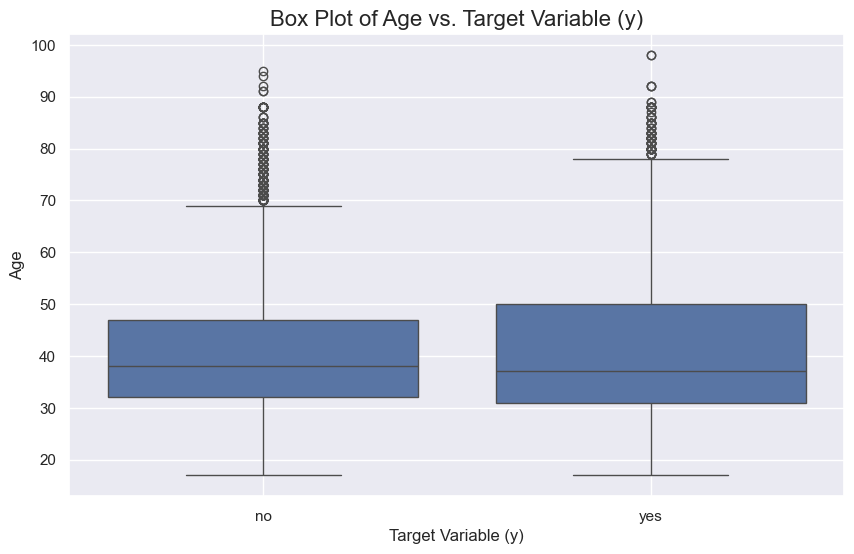

In [68]:
plt.figure(figsize=(10, 6))
# Create a box plot for 'age' by target variable 'y'
sns.boxplot(data=df_processed, x='y', y='age')
# Adding title and labels with improved font sizes
plt.title('Box Plot of Age vs. Target Variable (y)', fontsize=16)
plt.xlabel('Target Variable (y)', fontsize=12)
plt.ylabel('Age', fontsize=12)
# Add grid for better readability
plt.grid(True)
plt.show()

**Observation:**

There is no clear dependency on the year. The box plot shows the presence of outliers, but in both cases, the main data group is located in a similar age category, approximately between 30 and 48 years. However, individuals above and below this range are highly likely to fall into the 'yes' category. It is possible that age categories above and below the 30-48 range may have a slight impact on the final decision, though not significantly.

*age category*

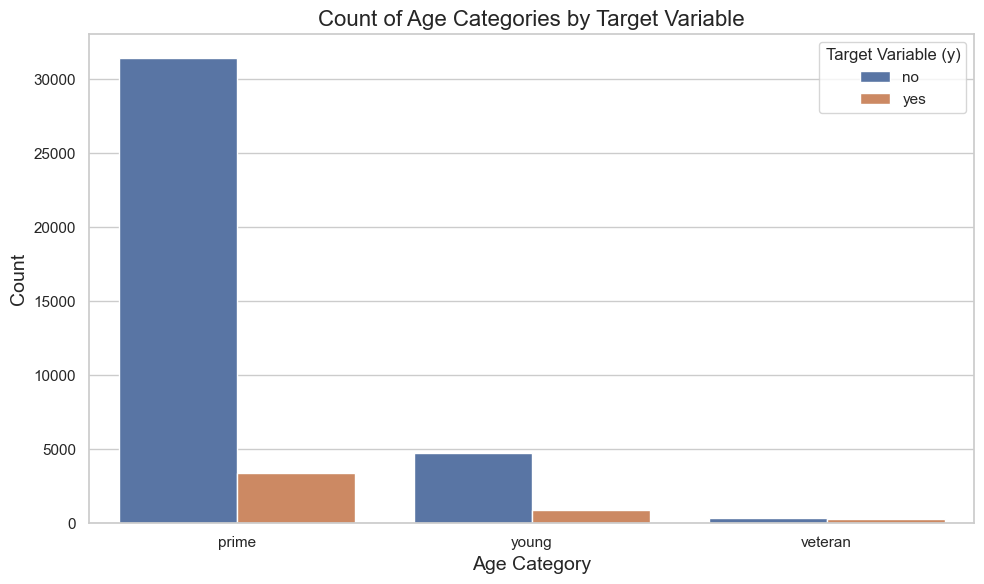

In [72]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='age_category', data=df_processed, hue='y')
plt.title('Count of Age Categories by Target Variable', fontsize=16)
plt.xlabel('Age Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Target Variable (y)', loc='upper right')
plt.tight_layout()
plt.show()

**Observation:**

There is a clear dependency within the age categories. 
The younger group tends to lean towards 'no' decisions, while the 'prime' age category shows a higher frequency of 'yes' decisions. 
The age category may have a significant impact on modeling, as older individuals (veterans) are more likely to agree. 

Additionally, younger people are generally more willing to take risks and engage in speculative investments, whereas older individuals prefer more stable options, such as bank accounts or bonds. 
Furthermore, older people tend to be less open-minded than younger individuals, which increases the likelihood that an older person will decide 'yes.'

*job*

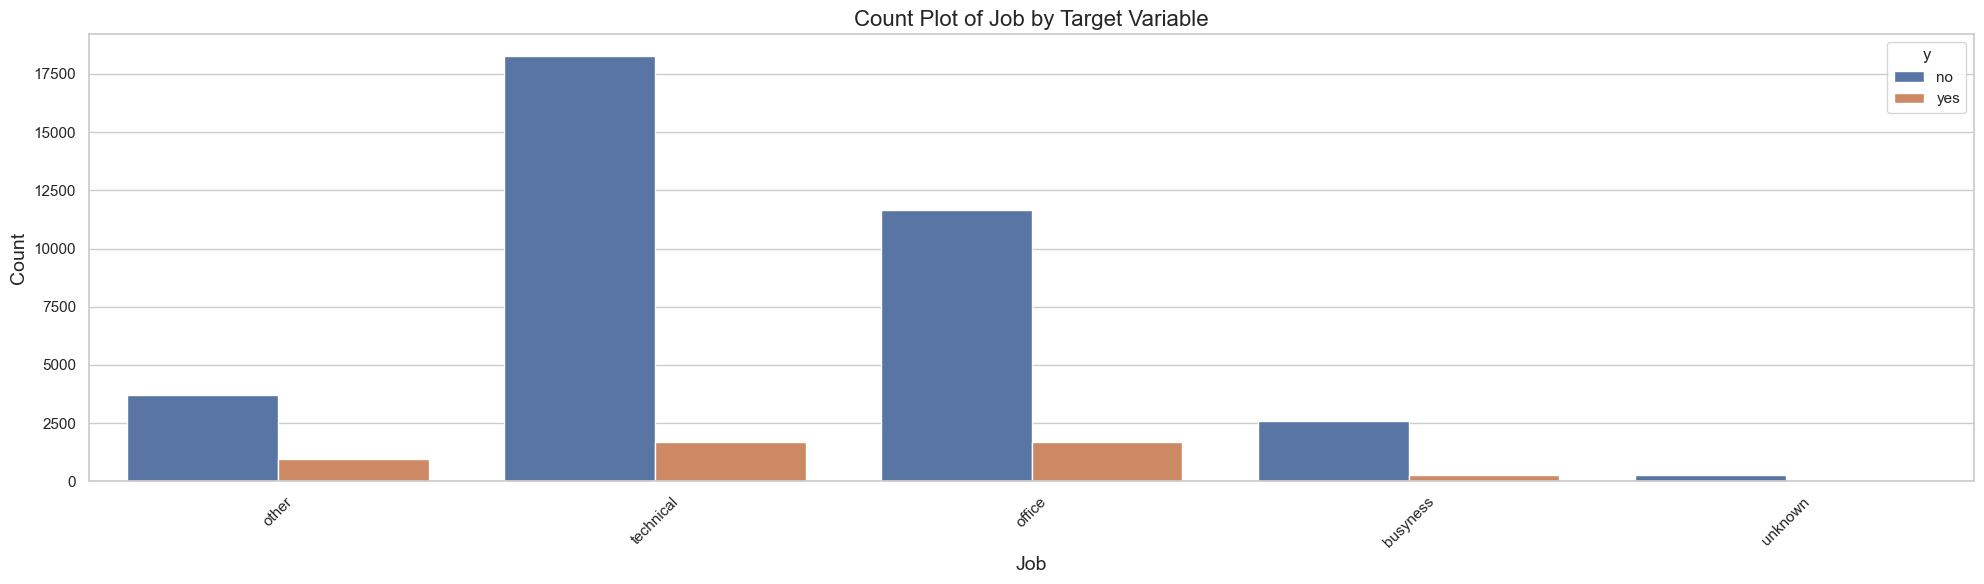

In [73]:
plt.figure(figsize=(20, 6))
# Create a count plot with better handling of hue
sns.countplot(x='job', data=df_processed, hue='y')
# Set the title and labels
plt.title('Count Plot of Job by Target Variable', fontsize=16)
plt.xlabel('Job', fontsize=14)
plt.ylabel('Count', fontsize=14)
# Rotate x-tick labels for better visibility if needed
plt.xticks(rotation=45)
# Display the plot
plt.tight_layout()
plt.show()


**Observation:**

The dominant job categories in the 'yes' group are "technical" and "office." However, when considering the ratio within each category, it is clear that the "other" category has the highest number of 'yes' samples relative to the total samples within that category. I suspect that the significant impact comes from students, which we will verify in the next plot. Therefore, I believe the job feature also has the potential to influence the outcome.

*job categories*

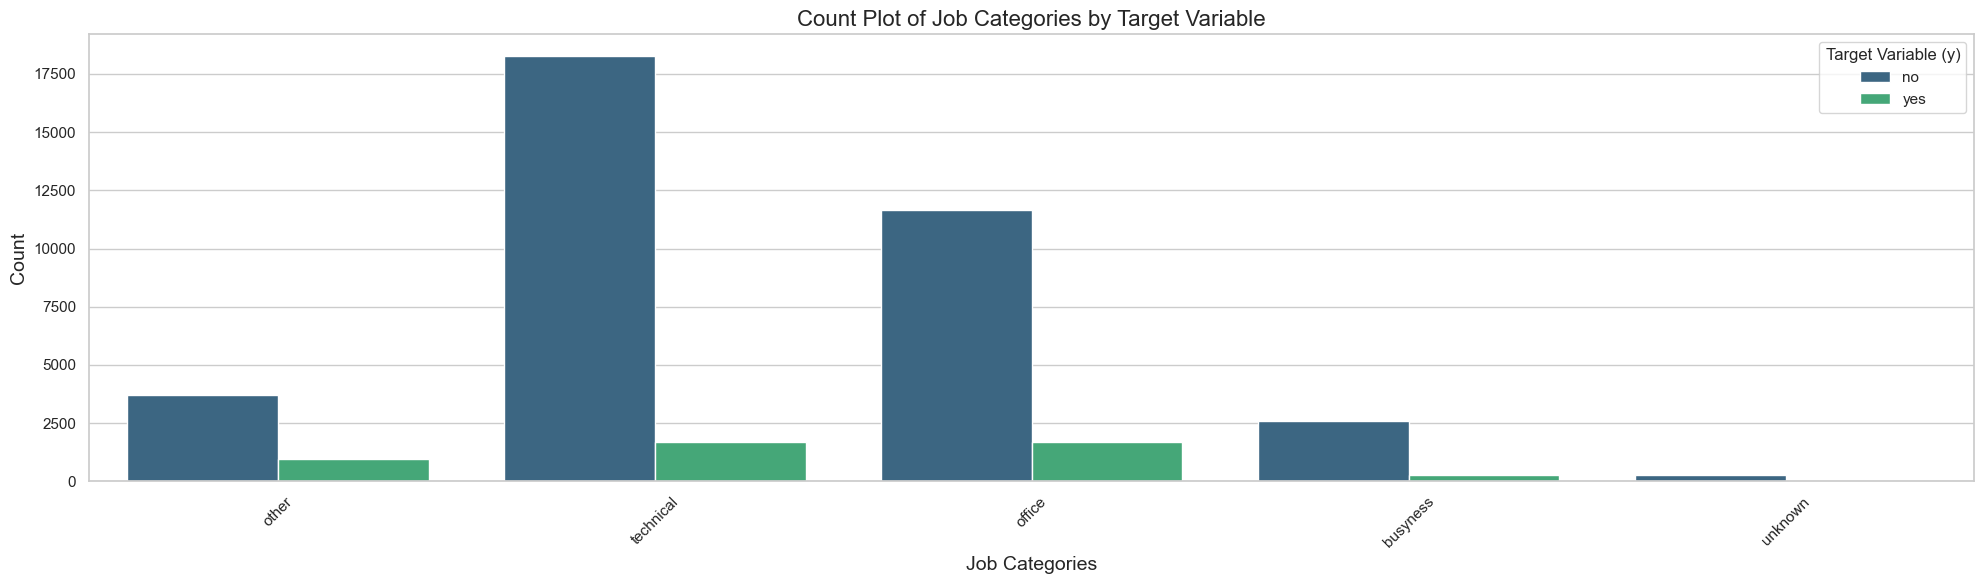

In [74]:
plt.figure(figsize=(20, 6))
# Create a count plot for job categories with the target variable as hue
sns.countplot(x='job', data=df, hue='y', palette='viridis')
plt.title('Count Plot of Job Categories by Target Variable', fontsize=16)
plt.xlabel('Job Categories', fontsize=14)
plt.ylabel('Count', fontsize=14)
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.legend(title='Target Variable (y)')
plt.tight_layout()
plt.show()

**Observation:**

Considering the total number of 'yes' samples per job group, the leading category is 'admin.' However, this category also has the highest number of 'no' samples, so we must analyze the ratio of total samples within each group and the ratio between 'yes' and 'no' responses. Based on this analysis, the highest proportion of 'yes' decisions belongs to the 'retired' and 'student' categories, which correlates with the visualization related to age categories. Conversely, the lowest ratios are observed in the 'unemployed,' 'self-employed,' and 'housemaid' categories.

From this observation, my theory is that this feature will significantly impact the outcomes. Moreover, from a business strategy perspective, the marketing team should focus its promotional efforts more on specific job categories.

*default*

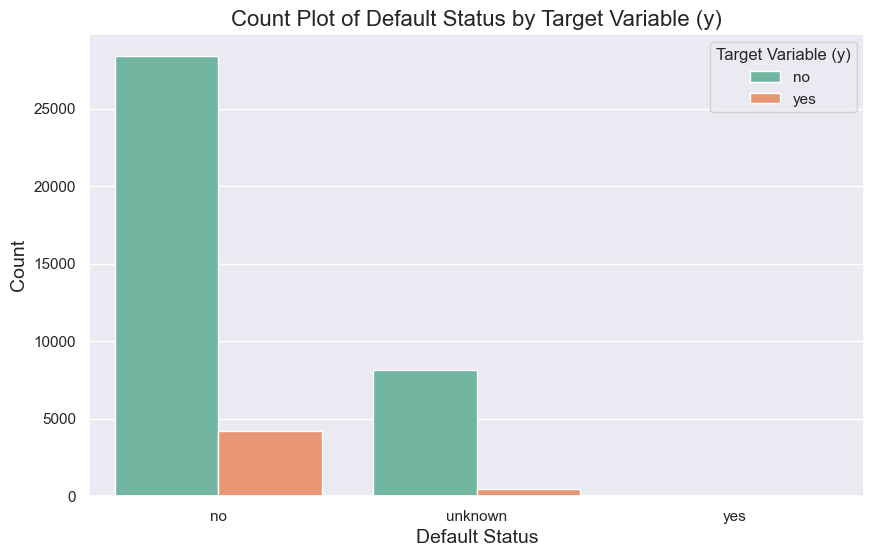

In [75]:
sns.set(rc={'figure.figsize': (10, 6)})
# Create count plot
sns.countplot(x='default', data=df_processed, hue='y', palette='Set2')
plt.title('Count Plot of Default Status by Target Variable (y)', fontsize=16)
plt.xlabel('Default Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
# Show the plot
plt.legend(title='Target Variable (y)')
plt.show()


**Observation:**

Most people are not in default, and those free from financial responsibilities are more likely to decide 'yes,' as seen in the plot. Conversely, the 'unknown' category shows the lowest ratio of 'yes' decisions relative to the total number of people in that group. It can be inferred that individuals may be reluctant to disclose their financial status, and those in default are more likely to respond 'no' or select 'unknown' compared to those without defaults. This behavior highlights the potential impact of financial status on decision-making.

*loan*

In [14]:
df_processed.loan.value_counts()

loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64

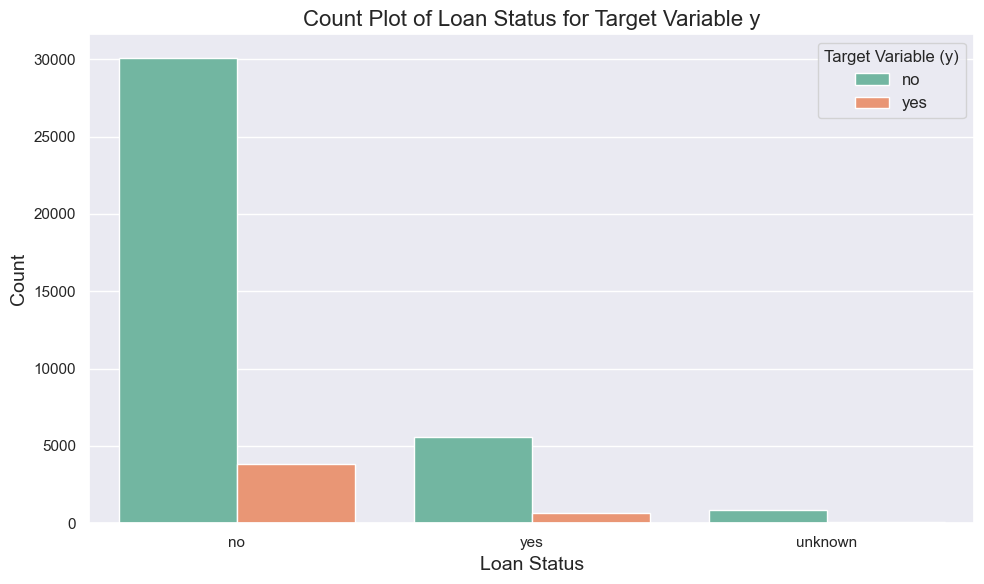

In [77]:
plt.figure(figsize=(10, 6))
# Create the count plot for the 'loan' feature
sns.countplot(x='loan', data=df_processed, hue='y', palette='Set2')
plt.title('Count Plot of Loan Status for Target Variable y', fontsize=16)
plt.xlabel('Loan Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Target Variable (y)', fontsize=12)
# Display the plot
plt.tight_layout()  
plt.show()


**Observation:**

The same pattern and tendency are visible in the case of the 'loan' feature. Similar to the 'default' variable, people with fewer financial resources are less likely to make a 'yes' decision.

*month*

2024-10-05 13:47:58,082 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-05 13:47:58,121 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


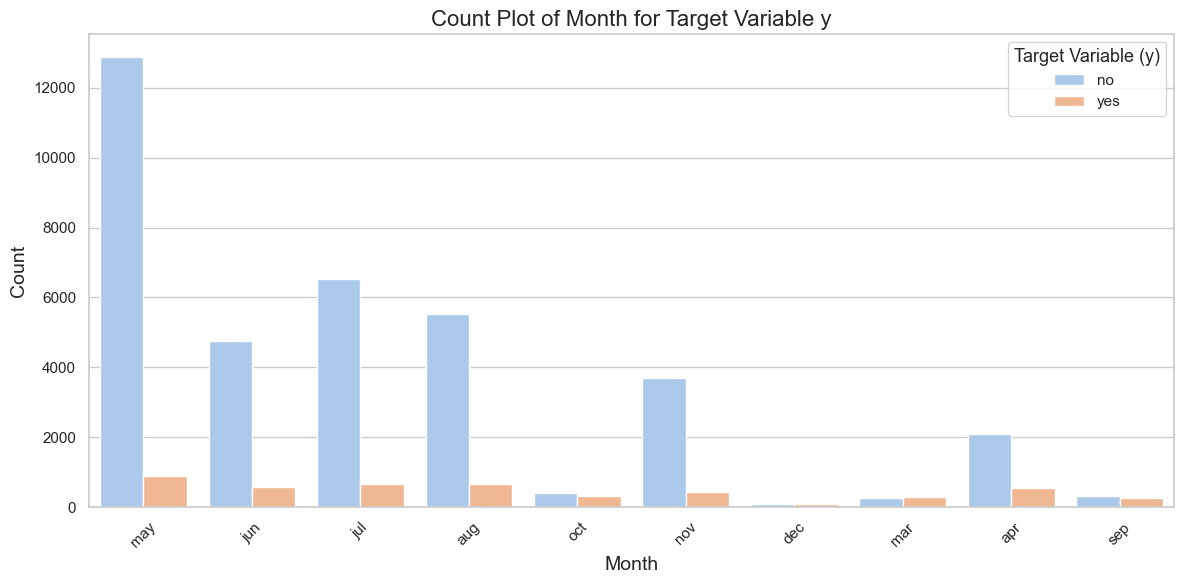

In [78]:
sns.set(rc={'figure.figsize': (12, 6)})
sns.set_style('whitegrid')
# Create the count plot
sns.countplot(x='month', data=df_processed, hue='y', palette='pastel')
# Add title and labels
plt.title('Count Plot of Month for Target Variable y', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
# Improve x-tick rotation for better readability
plt.xticks(rotation=45)
plt.legend(title='Target Variable (y)', title_fontsize='13', fontsize='11')
# Display the plot
plt.tight_layout()
plt.show()

**Observation:**

The highest number of contacts per month is observed in May, while December has the lowest. A moderate number of contacts is recorded in June, July, and August. It raises a good question: what is the basis for this trend? October, December, March, and September show the lowest statistics. Why is May particularly significant? One possible explanation is that the summer quarter is a vacation period, making people more available for contact. However, what about November? Perhaps "Black Friday" plays a role. While these trends are visible, they suggest a potential but not strong impact on decision-making.

*euribor3m*

2024-10-05 13:49:51,717 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-05 13:49:51,749 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


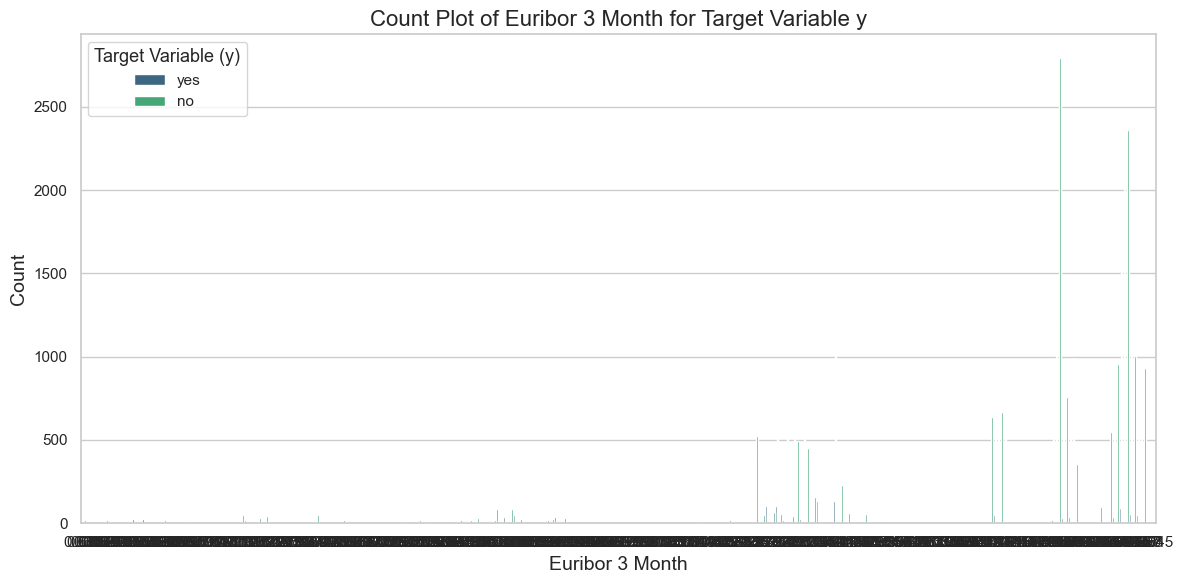

In [79]:
plt.figure(figsize=(12, 6))
# Create the count plot with improved aesthetics
sns.countplot(x='euribor3m', data=df, hue='y', palette='viridis')
plt.title('Count Plot of Euribor 3 Month for Target Variable y', fontsize=16)
plt.xlabel('Euribor 3 Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Target Variable (y)', title_fontsize='13', fontsize='11')
# Display the plot
plt.tight_layout()
plt.show()

**Observation:**

EURIBOR – (Euro Interbank Offered Rate) – is the interest rate (reference indicator) at which banks are willing to lend euros to other banks in the Eurozone interbank market. Certain values of EURIBOR show a strong decline toward 'yes' decisions, leading to the conclusion that this feature will definitely impact customer decisions. The business team must consider this macroeconomic statistic and engage customers more frequently than usual.

This time period is influenced by macroeconomic parameters that can increase the number of customers. Lower interest rates equate to "cheap" money, which means lower costs for credit. As a result, banks can propose more benefits to clients and vice versa.

*empvarrate*

2024-10-05 13:55:42,940 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-05 13:55:42,971 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


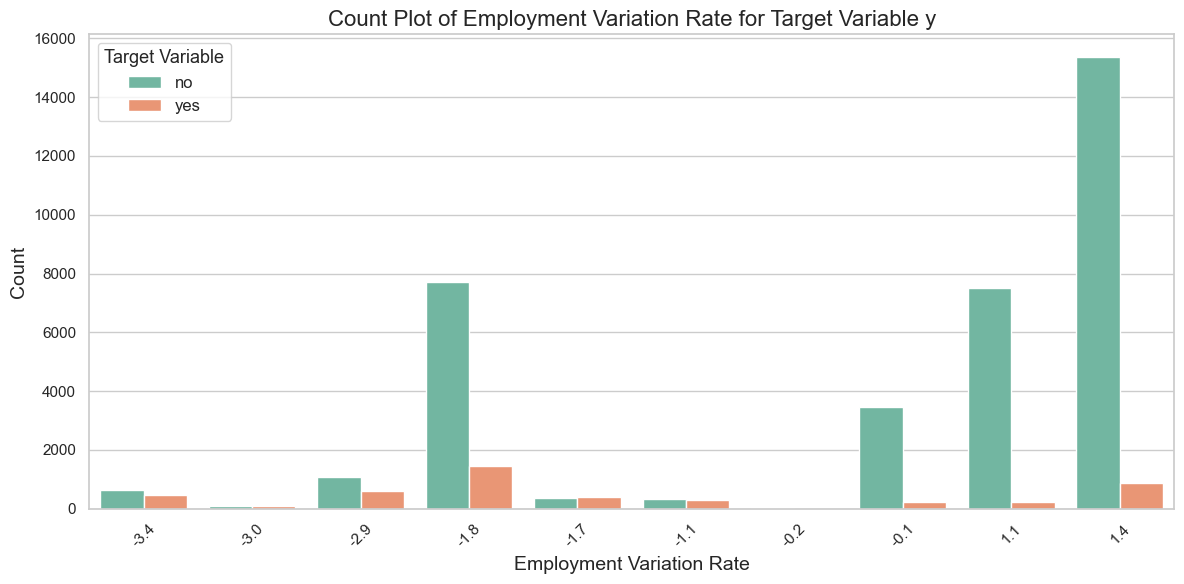

In [80]:
plt.figure(figsize=(12, 6))
# Create count plot for empvarrate with hue for target variable
sns.countplot(x='empvarrate', data=df, hue='y', palette='Set2')
plt.title('Count Plot of Employment Variation Rate for Target Variable y', fontsize=16)
plt.xlabel('Employment Variation Rate', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Target Variable', title_fontsize='13', fontsize='12')
# Show the plot
plt.tight_layout()
plt.show()

**Observation:**

A similar trend is observed in the case of EURIBOR, with notable peaks at values of -1.8 and 1.4, which warrant further investigation. Additional macroeconomic parameters exhibiting a strong decision-making pattern should be considered by the marketing business team. It might be beneficial to propose more incentives to customers during these periods.

*nremployed*

2024-10-05 13:57:25,605 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-05 13:57:25,651 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


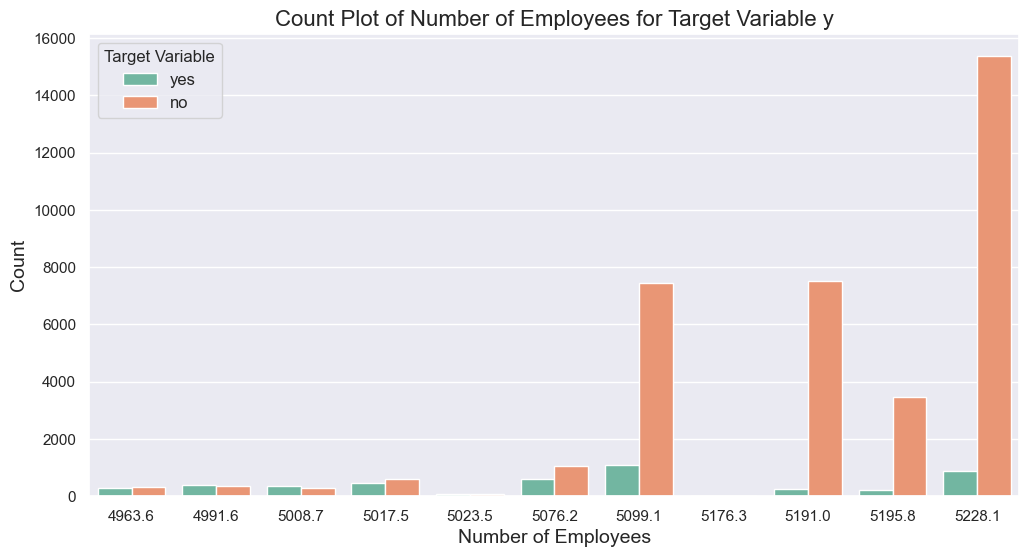

In [81]:
sns.set(rc={'figure.figsize': (12, 6)})
sns.countplot(x='nremployed', data=df, hue='y', palette='Set2')  
plt.title('Count Plot of Number of Employees for Target Variable y', fontsize=16)  
plt.xlabel('Number of Employees', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Target Variable', fontsize=12)
plt.show()

**Observation:**

Such macroeconomic parameters should be considered as well, as we can observe a strong inclination towards 'no' decisions with an increase in the total number of employed people. While there is no strong recommendation, these anomalies are a good point for further investigation. More employed people typically indicate a strong macroeconomic state, which, in turn, means lower interest rates on deposits. Consequently, people earn less from saving money in banks and are more likely to invest in riskier activities. This tendency may explain the trend of rising 'no' decisions alongside an increase in the total number of employed individuals. This parameter should also be considered by the marketing team in their business strategy.

*conspriceidx*

2024-10-05 14:01:02,156 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-05 14:01:02,198 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


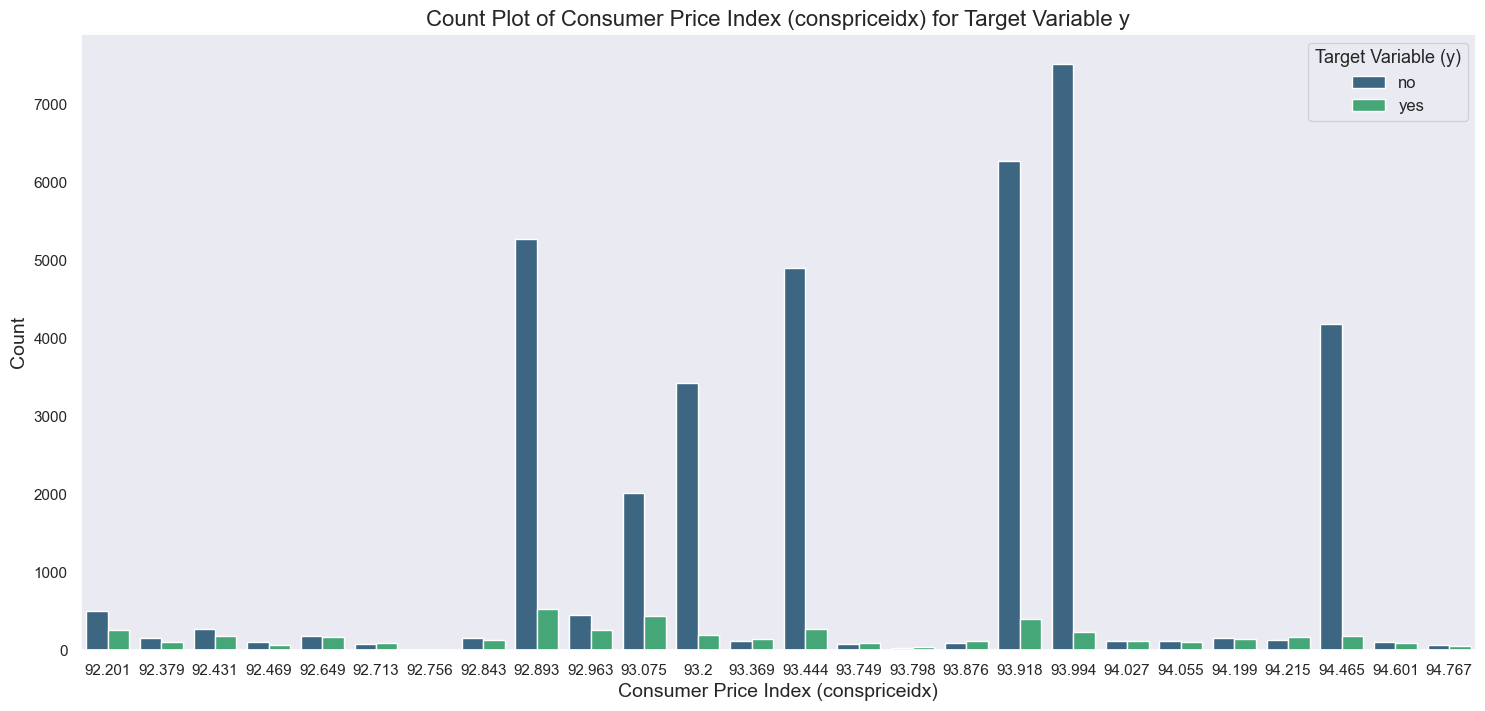

In [91]:
sns.set(rc={'figure.figsize': (18,8)})
# Create the count plot
sns.countplot(x='conspriceidx', data=df, hue='y', palette='viridis')
plt.title('Count Plot of Consumer Price Index (conspriceidx) for Target Variable y', fontsize=16)
plt.xlabel('Consumer Price Index (conspriceidx)', fontsize=14)
plt.ylabel('Count', fontsize=14)
# Show the plot
plt.legend(title='Target Variable (y)', title_fontsize='13', fontsize='12')
plt.grid(axis='y')
plt.show()

**Observation:**

The Consumer Confidence Index (CCI) measures the degree of optimism consumers have regarding current and expected economic conditions. There are numerous peaks visible, which indicate that more contacts were made during these periods, as shown in the monthly contact data.

However, there is something underlying these trends that requires further investigation, as additional data is needed for a more precise analysis. Some periods show strong declines, during which people were more likely to make 'no' decisions or reject offers from banks.

It would be beneficial to conduct a deeper analysis to determine the specific time frames when these declines occurred and to identify the events or sentiments that dominated during those times. This feature holds significant potential for influencing decision-making and should be considered by the marketing team in their business strategy.

**Recommendations and conclusion:**

- Personal statistics are important, such as the **duration** of **contact**, the financial state of the individual or family, and the timing of the last contact. These factors have a strong potential to influence decision-making and **should be considered within the marketing strategy as well**.

- Based on the observations and data analysis, a strong potential impact of macroeconomic statistics has been identified. This impact must be considered by the BAU team to enhance their marketing strategy in light of the provided insights. **However, a deeper analysis is necessary to obtain a clearer overview of macroeconomic statistics, as there is also a tendency for an increased number of contacts with customers. Additionally, I would like to analyze time series data for better insight into the situation. For now, I cannot conclude that these parameters should be dropped from consideration, as they have a high potential to impact the model and may lead to more false positive decisions.**

**The AutoEDA class was developed to extract essential information for model parameterization and selection, including missing values, balance in label distribution, and other key metrics. This functionality helps streamline the exploratory data analysis process, providing insights necessary for effective modeling. The class aims to simplify data preparation and enhance the overall efficiency of the modeling workflow.**

Missing Values:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


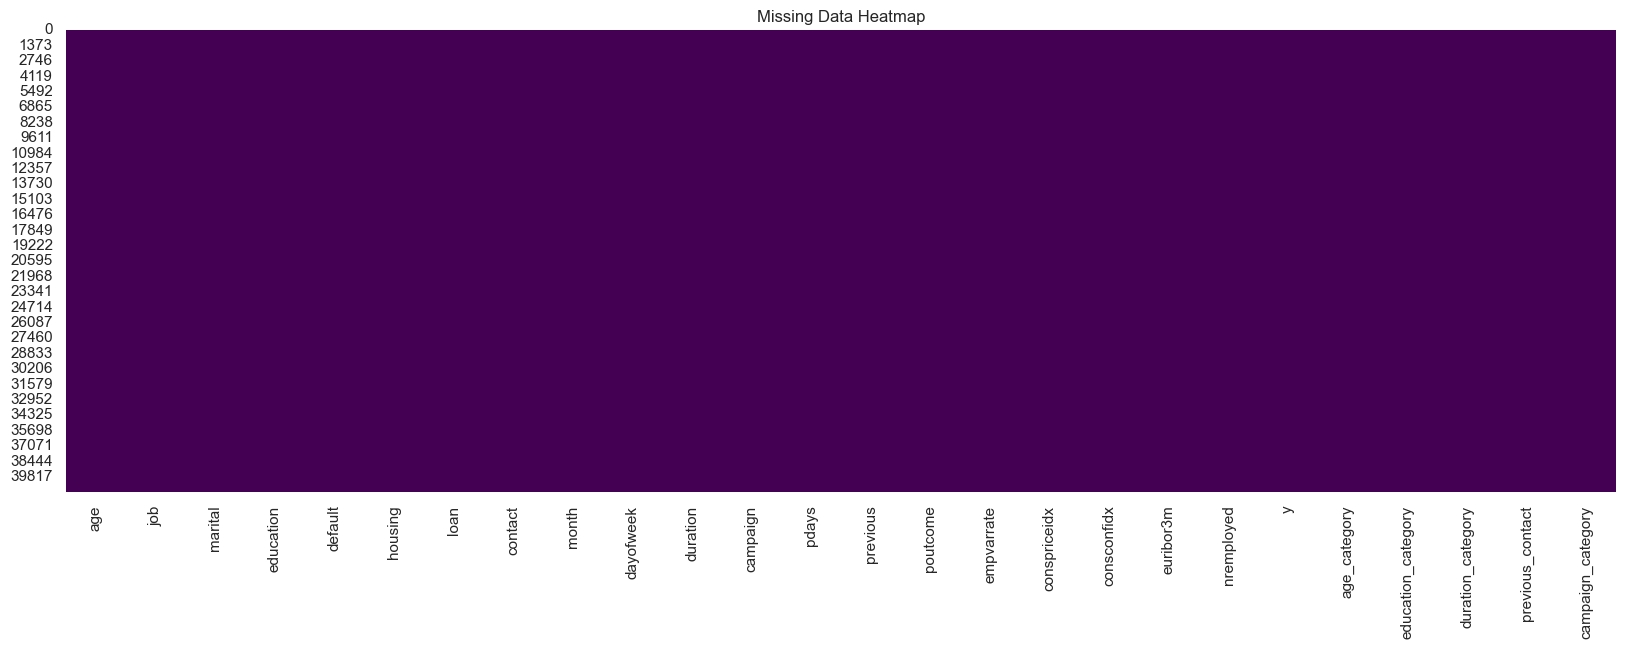


Summary Statistics:
                      count         mean         std       min       25%  \
age                 41188.0    40.024060   10.421250    17.000    32.000   
job                 41188.0     2.037050    1.057773     0.000     1.000   
marital             41188.0     1.172769    0.608902     0.000     1.000   
education           41188.0     3.747184    2.136482     0.000     2.000   
default             41188.0     0.208872    0.406686     0.000     0.000   
housing             41188.0     1.071720    0.985314     0.000     0.000   
loan                41188.0     0.327425    0.723616     0.000     0.000   
contact             41188.0     0.365252    0.481507     0.000     0.000   
month               41188.0     4.230868    2.320025     0.000     3.000   
dayofweek           41188.0     2.004613    1.397575     0.000     1.000   
duration            41188.0   258.285010  259.279249     0.000   102.000   
campaign            41188.0     2.567593    2.770014     1.000     

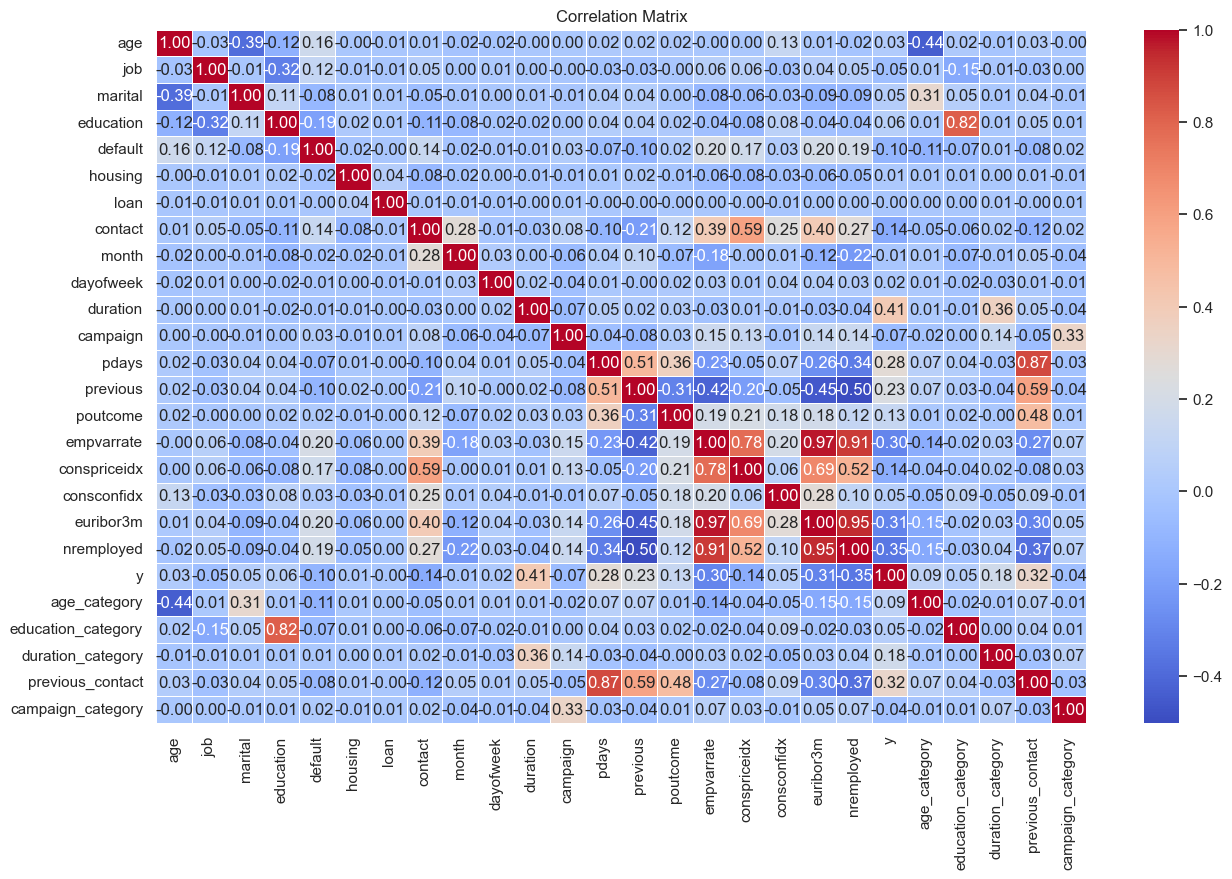

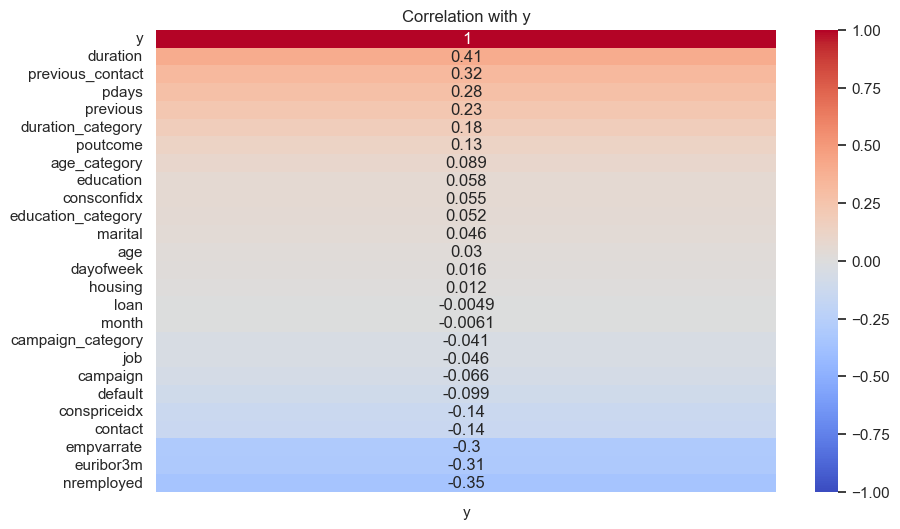


Correlation with Target (y):
y                     1.000000
duration              0.405274
previous_contact      0.324877
pdays                 0.279025
previous              0.230181
duration_category     0.177240
poutcome              0.129789
age_category          0.089067
education             0.057799
consconfidx           0.054878
education_category    0.051610
marital               0.046203
age                   0.030399
dayofweek             0.015967
housing               0.011552
loan                 -0.004909
month                -0.006065
campaign_category    -0.041072
job                  -0.045948
campaign             -0.066357
default              -0.099352
conspriceidx         -0.136211
contact              -0.144773
empvarrate           -0.298334
euribor3m            -0.307771
nremployed           -0.354678
Name: y, dtype: float64

Class Balance Check:
Class 0: 36548 instances, 88.73% of total
Class 1: 4640 instances, 11.27% of total


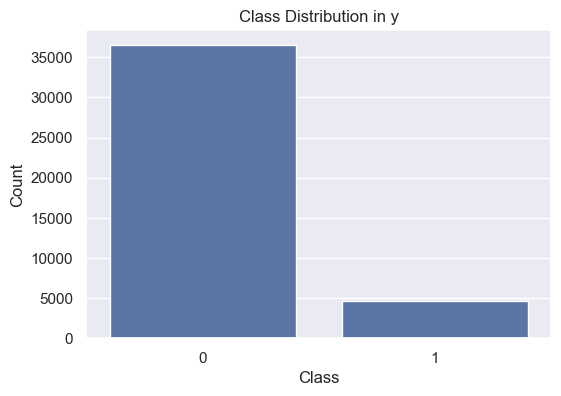

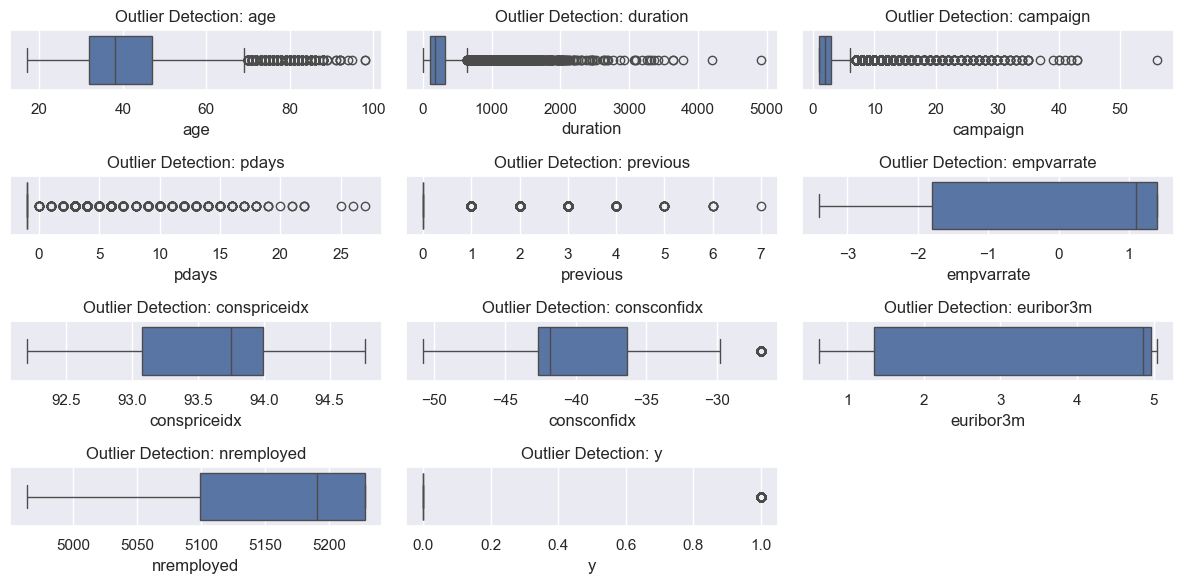

In [21]:
class AutoEDA:
    def __init__(self, df):
        """initialize the class with a DataFrame."""
        self.df = df
        self._encode_categorical_columns()
    def _encode_categorical_columns(self):
        """automatically encode categorical columns to numeric using Label Encoding."""
        categorical_cols = self.df.select_dtypes(include=['object']).columns
        self.label_encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            self.df[col] = le.fit_transform(self.df[col])
            self.label_encoders[col] = le  # Store the encoder for future reference if needed
    def missing_values(self):
        """display missing values count and percentage."""
        missing_data = self.df.isnull().sum()
        missing_percentage = (self.df.isnull().mean() * 100).round(2)
        missing_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})
        return missing_df[missing_df['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)
    def display_missing_vals(self):
        """plot the heatmap with missing values"""
        sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
        plt.title('Missing Data Heatmap')
        return plt.show()
    def summary_stats(self):
        """show summary statistics of numeric columns."""
        return self.df.describe(include = 'all').T
    def correlation_matrix(self):
        """plot a correlation heatmap."""
        plt.figure(figsize=(15, 9))
        sns.heatmap(self.df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Matrix')
        plt.show()
    def target_correlation(self, target):
        """show correlation of all variables with the target variable."""
        correlations = self.df.corr()[target].sort_values(ascending=False)
        return correlations
    def target_corr_stage(self, target):
        """show the stage of feature corr in relation to target"""
        le = LabelEncoder()
        df[target] = le.fit_transform(df[target])
        # Convert all other categorical columns to numeric (if needed)
        df_numeric = df.select_dtypes(include=[int, float])
        # Compute correlation matrix
        corr = df_numeric.corr()
        # Extract correlations with the target variable
        target_corr = corr[[target]].sort_values(by=target, ascending=False)
        # Create a heatmap of correlations
        plt.figure(figsize=(10, 6))
        sns.heatmap(target_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f'Correlation with {target}')
        return plt.show()
    def outlier_detection(self):
        """detect outliers using box plots."""
        numeric_cols = self.df.select_dtypes(include=['float64', 'int64']).columns
        plt.figure(figsize=(12, 6))
        for i, col in enumerate(numeric_cols, 1):
            plt.subplot(len(numeric_cols)//3+1, 3, i)
            sns.boxplot(x=self.df[col])
            plt.title(f'Outlier Detection: {col}')
        plt.tight_layout()
        plt.show()
    def balance_in_target(self, target):
        """check the balance of classes in the target column."""
        target_counts = self.df[target].value_counts()
        total = len(self.df)
        for label, count in target_counts.items():
            print(f"Class {label}: {count} instances, {count / total * 100:.2f}% of total")
        plt.figure(figsize=(6, 4))
        sns.barplot(x=target_counts.index, y=target_counts.values)
        plt.title(f'Class Distribution in {target}')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.show()
    def run_eda(self, target=None):
        """run all EDA steps automatically."""
        print("Missing Values:")
        print(self.missing_values())
        self.display_missing_vals()
        print("\nSummary Statistics:")
        print(self.summary_stats())
        self.correlation_matrix()
        self.target_corr_stage(target)
        if target:
            print(f"\nCorrelation with Target ({target}):")
            print(self.target_correlation(target))
            print("\nClass Balance Check:")
            self.balance_in_target(target)
        self.outlier_detection()

eda = AutoEDA(df)
eda.run_eda(target='y')

#### Key statistics
**missing values and duplicates:**
- No missing values detected.
- Duplicates present but not a concern due to similar categories/encoding.
**age:**
- Mean: **40.11** years (SD: **10.31**)
- Range: **18** to **88** years
- Percentiles: 25th - **32**, Median - **38**, 75th - **47**
**job:**
- Mean encoding: **3.82** (SD: **3.61**)
- Range: **0** to **11** (75th percentile: **7**)
**marital status:**
- Mean: **1.18** (SD: **0.61**)
- Range: **0** to **3** (likely indicating 'married')
**education:**
- Mean: **3.78** (SD: **2.15**)
- Range: **0** to **7** (75th percentile: **6**)
**default:**
- Mean default rate: **0.195** (19.5% defaulted, SD: **0.397**)
**housing:**
- Mean: **1.08** (indicates many clients have housing loans)
**loan:**
- Mean: **0.35** (about **35%** have personal loans)
**contact:**
- Mean encoding: **0.36** (binary contact types, max: **1**)
**month:**
- Average contact month: **4.29** (indicating mid-year frequency)
**day of week:**
- Average: **2.01** (encoded from **0** to **4**)
**duration:**
- Mean call duration: **256.79** seconds (SD: **254.70**)
- 75th percentile: **317** seconds (max: **3643** seconds)
**campaign:**
- Mean contacts during the campaign: **2.54** (up to **35** contacts)
**pdays:**
- Majority have not been contacted in previous campaigns (**999**)
**previous:**
- Mean previous contacts: **0.19** (most not contacted)
**poutcome:**
- Mean outcome: **0.92** (mostly unsuccessful)

#### economic indicators:
- **Employment Variation Rate**: Mean **0.085** (slight positive variation)
- **Consumer Price Index**: Mean **93.58**
- **Consumer Confidence Index**: Mean **-40.50** (negative sentiment)
- **Euribor 3M**: Mean **3.62**
- **Number of Employees**: Mean **5166.48**
#### target variable (y)
- Mean: **0.109** (around **10.9%** subscribed to term deposits)
#### insights:
- Dataset contains a mix of categorical and numeric variables.
- Most clients did not default, take loans, or subscribe.
- High variance in **duration** and **campaign** indicates diverse interactions.
- Economic indicators suggest negative sentiment during the campaign.
#### correlation with target (y)
#### positive correlations
- **Duration**: **0.419** (longer calls = higher subscription likelihood)
- **Previous**: **0.256** (more previous contacts = slightly higher likelihood)
- **Poutcome**: **0.123** (mildly positive)
- **Education**: **0.067**
- **Age**: **0.060**
- **Consumer Confidence Index**: **0.054**
- **Marital Status**: **0.044**
- **Job**: **0.027**
- **Month**: **0.005**
- **Housing**: **0.001**
#### negative correlations
- **Day of Week**: **-0.006**
- **Loan**: **-0.013**
- **Campaign**: **-0.076** (more contacts = lower likelihood)
- **Default**: **-0.077**
- **Consumer Price Index**: **-0.098**
- **Contact**: **-0.137**
- **Employment Variation Rate**: **-0.283**
- **Euribor 3M**: **-0.299**
- **Pdays**: **-0.332**
- **Number of Employees**: **-0.349**
#### further insights
- The target variable "y" is imbalanced; consider techniques like SMOTE or class weight adjustments.
- **Duration** is the most significant positive factor for subscription.
- Economic factors (**Employment Variation Rate**, **Euribor 3M**, **pdays**, **Number of Employees**) strongly influence subscription likelihood.
- Demographic factors (**age**, **education**, **marital status**) show weaker predictive power compared to call-related factors and economic indicators.

#### experimental evaluation preprocessing

**Feature selection sechniques + SMOTE**
In this project, feature selection optimizes model performance by identifying impactful features and eliminating irrelevant ones. This enhances efficiency and accuracy. Following feature selection, SMOTE (Synthetic Minority Over-sampling Technique) addresses class imbalance by generating synthetic examples of the minority class, ensuring balanced training data.

**Recursive Feature Elimination (RFE):**
RFE systematically ranks and selects the best subset of features by fitting a machine learning model and recursively removing the least important ones. This process continues until only the most relevant features remain, improving the model's predictive power and reducing overfitting.

**The script preprocesses a dataset by separating features (X) and the target variable (y), applying SMOTE to address class imbalance, and scaling numerical features using StandardScaler.
It then splits the dataset into training and testing sets before defining several estimators, including Decision Tree, Random Forest, Gradient Boosting, and XGBoost classifiers, and performs feature selection using Recursive Feature Elimination (RFE) for each model, printing the selected features.
The script further counts and visualizes the frequency of selected features across models, retaining the top features for subsequent modeling, after which it trains each estimator and evaluates performance using accuracy, precision, recall, and F1 score.
Finally, it employs RandomizedSearchCV to optimize hyperparameters for each model, reporting the best parameters and scores while retraining the models with these optimized settings and assessing their performance on the test data.**


In [31]:
def encode_object_columns(df):
    """
    iterates through each column in the dataset and encodes the columns
    with 'object' data type using one-hot encoding.
    parameters:
    df (pd.DataFrame): The input dataframe to be encoded.
    returns:
    pd.DataFrame: The dataframe with encoded categorical columns.
    """
    # print basic stats about df
    print(f'shape of dataset is: {df.shape}')
    print(f'value counts in target column: {df[target].value_counts()}')
    # object-type (categorical) columns search
    object_columns = df.select_dtypes(include=['object']).columns
    # one-hot encoding to the categorical columns
    df_encoded = pd.get_dummies(df, columns=object_columns, drop_first=True)
    return df_encoded

df_processed = encode_object_columns(df_processed)
df_processed.head()

shape of dataset is: (41188, 26)
value counts in target column: y
0    36548
1     4640
Name: count, dtype: int64


,age,job,marital,education,default,housing,loan,contact,month,dayofweek,...,conspriceidx,consconfidx,euribor3m,nremployed,y,age_category,education_category,duration_category,previous_contact,campaign_category
0,56,2,1,0,0,0,0,1,6,1,...,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1
1,57,3,1,3,1,0,0,1,6,1,...,93.994,-36.4,4.857,5191.0,0,0,0,1,0,1
2,37,3,1,3,0,2,0,1,6,1,...,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1
3,40,1,1,1,0,0,0,1,6,1,...,93.994,-36.4,4.857,5191.0,0,0,0,1,0,1
4,56,3,1,3,0,0,2,1,6,1,...,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1


**Experiment run:**

In [23]:
# Separate features (X) and target (y)
X = df_processed.drop('y', axis=1)
y = df_processed['y']
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
# Create a new balanced DataFrame
balanced_df = pd.concat([X_resampled, y_resampled], axis=1)
# Check the class distribution in the balanced dataset
print(balanced_df['y'].value_counts())
df = balanced_df.copy()
print(df.shape)
ss = StandardScaler()
for column in df.select_dtypes(include=['number']).columns:
  if column != 'y':
    df[column] = ss.fit_transform(df[[column]])
display(df.head())
# Assuming X and y are your features and target variable
X = df.drop('y', axis=1)
y = df['y']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)
# Define the estimators
estimators = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()
]
# Loop through the estimators and perform feature selection
for estimator in estimators:
  print(f"Performing feature selection with {type(estimator).__name__}")
  # Create RFE object with the estimator and desired number of features to select
  rfe = RFE(estimator=estimator, n_features_to_select=12)  # You can adjust the number of features
  # Fit RFE to the training data
  rfe.fit(X_train, y_train)
  # Get the selected features
  selected_features = X_train.columns[rfe.support_]
  # Print the selected features
  print("Selected Features:", selected_features)
  print("-" * 100)
# Assuming you have a list of selected features for each model
# Create a dictionary to store the feature counts
feature_counts = {}
for estimator in estimators:
  rfe = RFE(estimator=estimator, n_features_to_select=8)
  rfe.fit(X_train, y_train)
  selected_features = X_train.columns[rfe.support_]
  for feature in selected_features:
    if feature in feature_counts:
      feature_counts[feature] += 1
    else:
      feature_counts[feature] = 1
# Sort features by count in descending order
sorted_features = sorted(feature_counts.items(), key=lambda item: item[1], reverse=True)
# Get the top features
top_features = [feature for feature, count in sorted_features]
# Print the overall top features
print("Overall Top Features:", top_features)
# Create a new DataFrame with only the top 10 features and the target variable
df_top = df[top_features + ['y']]
# Separate features (X) and target (y) from the new DataFrame
X = df_top.drop('y', axis=1)
y = df_top['y']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# train models
for estimator in estimators:
  estimator.fit(X_train, y_train)
  y_pred = estimator.predict(X_test)
  print(f"Model: {type(estimator).__name__}")
  print(f'Accuracy Score : {accuracy_score(y_test,y_pred):.2f}')
  print(f'Precision Score : {precision_score(y_test,y_pred):.2f}')
  print(f'Recall Score : {recall_score(y_test,y_pred):.2f}')
  print(f'F1_Score : {f1_score(y_test,y_pred):.2f}')
  print("-" * 50)
  print(classification_report(y_test, y_pred))
  print("-" * 50)
  print(f'This model : {type(estimator).__name__} done train!')
  print(confusion_matrix(y_test, y_pred))
  print("-" * 50)
# Define parameter distributions for each model
param_distributions = {
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': randint(2, 10),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10)
    },
    'RandomForestClassifier': {
        'n_estimators': randint(50, 200),
        'max_depth': randint(2, 10),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'bootstrap': [True, False]
    },
    'GradientBoostingClassifier': {
        'n_estimators': randint(50, 200),
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': randint(2, 10),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10)
    },
    'XGBClassifier': {
        'n_estimators': randint(50, 200),
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': randint(2, 10),
        'min_child_weight': randint(1, 10),
        'gamma': [0, 0.1, 0.2]
    }
}
# Perform RandomizedSearchCV for each model
for estimator in estimators:
  model_name = type(estimator).__name__
  print(f"Performing RandomizedSearchCV for {model_name}")
  # Create RandomizedSearchCV object
  random_search = RandomizedSearchCV(
      estimator=estimator,
      param_distributions=param_distributions.get(model_name, {}),
      n_iter=20,  # Number of parameter settings that are sampled
      cv=5,
      scoring='f1',  # You can choose other scoring metrics
      random_state=42,
      n_jobs=-1  # Use all available CPU cores
  )
  # Fit RandomizedSearchCV to the training data
  random_search.fit(X_train, y_train)
  # Print the best parameters and score
  print("Best Parameters:", random_search.best_params_)
  print("Best Score:", random_search.best_score_)
  print("-" * 50)
  # Train the model with the best parameters
  best_estimator = random_search.best_estimator_
  best_estimator.fit(X_train, y_train)
  # Make predictions on the test set
  y_pred = best_estimator.predict(X_test)
  # Evaluate the model
  print(f"Model: {model_name} with best parameters")
  print(f'Accuracy Score : {accuracy_score(y_test,y_pred):.2f}')
  print(f'Precision Score : {precision_score(y_test,y_pred):.2f}')
  print(f'Recall Score : {recall_score(y_test,y_pred):.2f}')
  print(f'F1_Score : {f1_score(y_test,y_pred):.2f}')
  print("-" * 50)
  print(classification_report(y_test, y_pred))
  print("-" * 50)
  print(f'This model : {model_name} with best parameters done train!')

y
0    36548
1    36548
Name: count, dtype: int64
(73096, 26)


,age,job,marital,education,default,housing,loan,contact,month,dayofweek,...,conspriceidx,consconfidx,euribor3m,nremployed,age_category,education_category,duration_category,previous_contact,campaign_category,y
0,1.370151,0.159661,-0.174123,-1.860025,-0.379735,-1.039735,-0.419537,1.802643,0.770208,-0.658541,...,0.824956,0.715214,1.002247,0.639079,-0.45689,-0.736086,-0.802933,-0.261782,-0.228397,0
1,1.456263,1.157058,-0.174123,-0.369754,2.631453,-1.039735,-0.419537,1.802643,0.770208,-0.658541,...,0.824956,0.715214,1.002247,0.639079,-0.45689,-0.736086,-0.154139,-0.261782,-0.228397,0
2,-0.265976,1.157058,-0.174123,-0.369754,-0.379735,1.099978,-0.419537,1.802643,0.770208,-0.658541,...,0.824956,0.715214,1.002247,0.639079,-0.45689,-0.736086,-0.802933,-0.261782,-0.228397,0
3,-0.007640,-0.837737,-0.174123,-1.363268,-0.379735,-1.039735,-0.419537,1.802643,0.770208,-0.658541,...,0.824956,0.715214,1.002247,0.639079,-0.45689,-0.736086,-0.154139,-0.261782,-0.228397,0
4,1.370151,1.157058,-0.174123,-0.369754,-0.379735,-1.039735,2.812766,1.802643,0.770208,-0.658541,...,0.824956,0.715214,1.002247,0.639079,-0.45689,-0.736086,-0.802933,-0.261782,-0.228397,0


Performing feature selection with DecisionTreeClassifier
Selected Features: Index(['age', 'job', 'education', 'contact', 'dayofweek', 'duration',
       'campaign', 'pdays', 'conspriceidx', 'consconfidx', 'euribor3m',
       'nremployed'],
      dtype='object')
----------------------------------------------------------------------------------------------------
Performing feature selection with RandomForestClassifier
Selected Features: Index(['age', 'job', 'education', 'contact', 'duration', 'pdays', 'empvarrate',
       'conspriceidx', 'consconfidx', 'euribor3m', 'nremployed',
       'duration_category'],
      dtype='object')
----------------------------------------------------------------------------------------------------
Performing feature selection with GradientBoostingClassifier
Selected Features: Index(['job', 'education', 'default', 'housing', 'loan', 'contact', 'duration',
       'pdays', 'empvarrate', 'consconfidx', 'euribor3m', 'nremployed'],
      dtype='object')
---------

**conclusion:**

- **top performers:** the **gradientboostingclassifier** and **randomforestclassifier**, especially after fine-tuning their hyperparameters, have emerged as the top models, achieving impressive accuracy scores of **0.95**. gradient boosting excels with a precision of **0.94** and a recall of **0.96**, while the random forest model also shows strong recall at **0.96**. these models are our best bets for deployment because they reliably predict positive outcomes with very few errors.
- the **xgbclassifier** also stands out with an accuracy of **0.94**, a precision of **0.92**, and a recall of **0.96**. it's a dependable option that performs similarly to gradient boosting and random forest, particularly after we've adjusted its settings.
- on the other hand, the **decisiontreeclassifier** is decent but comes in last with an accuracy of **0.92**. while it’s easier and quicker to deploy, it doesn’t quite measure up to the ensemble methods (like gradient boosting, random forest, and xgboost) in terms of precision and recall.

**recommendation:**

- for final deployment, we recommend focusing on the **randomforestclassifier** or **xgbclassifier**. these models demonstrate excellent predictive capabilities and reliability. 
- however, considering the results of the confusion matrix, the **xgbclassifier** has been chosen. in addition, it is particularly useful in this case as many outliers were detected in the data, which cannot be dropped. it includes regularization for outliers (l1), making it more robust.



In [34]:
# do if nescessary
# pip install shap

**XGBClassifier + SHAP:**

**This script utilizes the SHAP package for model explanation and applies a Gradient Boosting classifier to identify optimal hyperparameters using GridSearchCV, assessing multiple scoring metrics including accuracy, precision, recall, and F1 score.
It defines a parameter grid for hyperparameter tuning, fits the model to the training data with cross-validation, and then retrieves the best model along with its optimal hyperparameters and scores.
The script calculates and visualizes feature importances from the best Gradient Boosting model using a bar plot, presenting features ranked by their importance scores.
Finally, it uses SHAP values to explain the model's predictions, generating a summary plot to highlight the impact of each feature on the model’s output, enhancing interpretability.**


Fitting 4 folds for each of 1296 candidates, totalling 5184 fits


c:\Users\mryok\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:20:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Best F1 Score: 0.9411306565979626


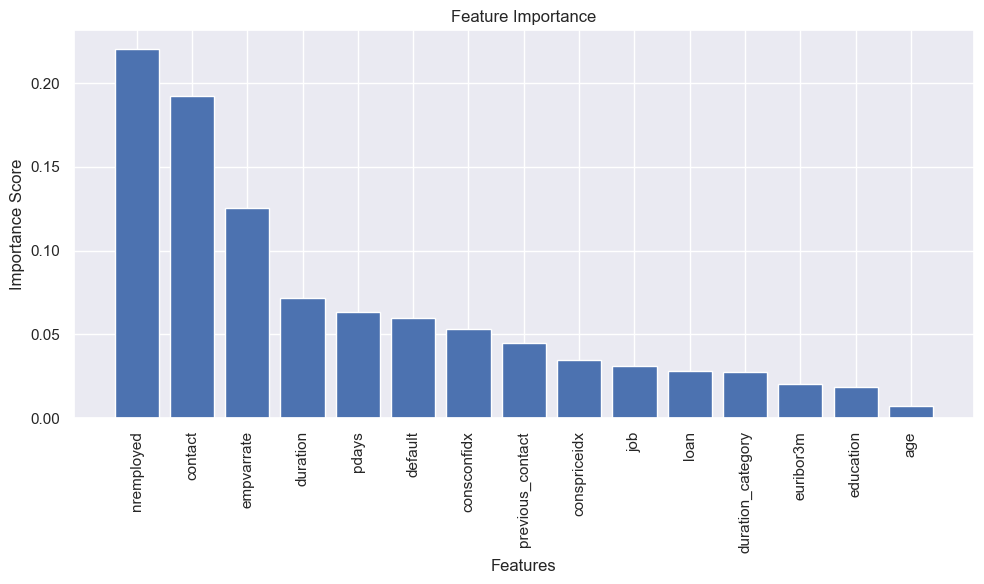

Feature: nremployed, Importance: 0.22050604224205017
Feature: contact, Importance: 0.19253922998905182
Feature: empvarrate, Importance: 0.1251920908689499
Feature: duration, Importance: 0.07166308909654617
Feature: pdays, Importance: 0.06365899741649628
Feature: default, Importance: 0.060073595494031906
Feature: consconfidx, Importance: 0.05333920940756798
Feature: previous_contact, Importance: 0.04472793638706207
Feature: conspriceidx, Importance: 0.03462839499115944
Feature: job, Importance: 0.03128590062260628
Feature: loan, Importance: 0.028348643332719803
Feature: duration_category, Importance: 0.027697516605257988
Feature: euribor3m, Importance: 0.02043994329869747
Feature: education, Importance: 0.018560189753770828
Feature: age, Importance: 0.007339163217693567


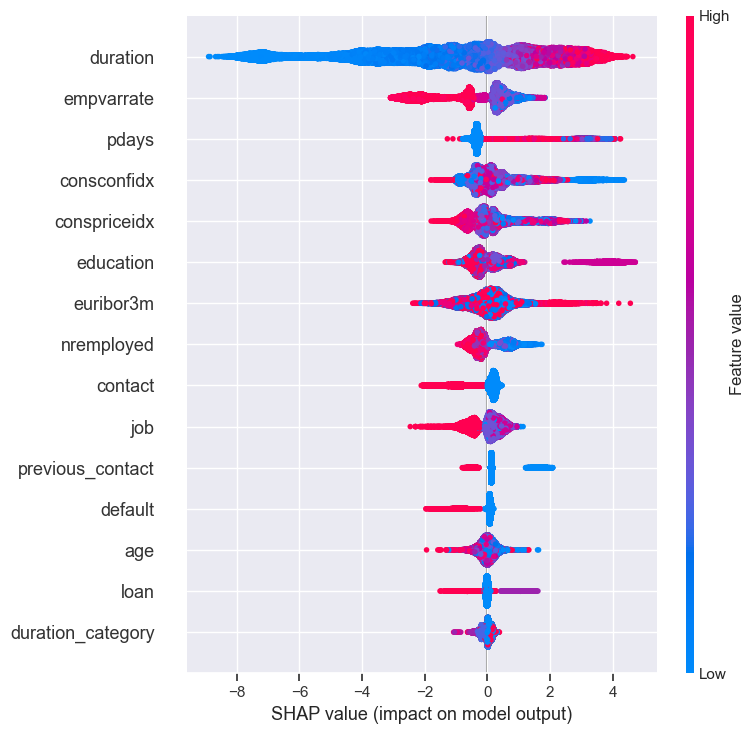

In [32]:
# Instantiate the XGBoost classifier
import shap
import xgboost as xgb
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],                # Number of boosting stages
    'learning_rate': [0.001, 0.01, 0.1, 0.2],      # Learning rate
    'max_depth': [3, 4, 5, 6],                     # Maximum depth of individual trees
    'min_child_weight': [1, 2, 4],                 # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.8, 0.9, 1.0],                   # Fraction of samples to use for fitting individual base learners
    'colsample_bytree': [0.8, 0.9, 1.0]            # Fraction of features to use when building trees
}
# Define the scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']
# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(estimator=xgb_model,
                      param_grid=param_grid,
                      scoring=scoring,
                      refit='f1',  # Refits on the best model based on f1-score
                      cv=4,        # Cross-validation with 4 folds
                      return_train_score=True,
                      n_jobs=-1,   # Utilize all cores for parallel processing
                      verbose=1)   # Verbose output to monitor progress

# Fit the model to the training data
xgb_cv.fit(X_train, y_train)
# Display the best hyperparameters and corresponding scores
print(f"Best Parameters: {xgb_cv.best_params_}")
print(f"Best F1 Score: {xgb_cv.best_score_}")
# Access the best estimator (model) and use it for further predictions
best_xgb_model = xgb_cv.best_estimator_
# Get feature importances from the best XGBoost model
feature_importances = best_xgb_model.feature_importances_
# Sort the feature importances in descending order and get the indices
sorted_idx = np.argsort(feature_importances)[::-1]
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), X_train.columns[sorted_idx], rotation=90)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()
# Optionally, you can print the features and their importance values
for idx in sorted_idx:
    print(f"Feature: {X_train.columns[idx]}, Importance: {feature_importances[idx]}")
# SHAP explanation
# Initialize the SHAP explainer
explainer = shap.Explainer(best_xgb_model)
# Calculate SHAP values for the training data
shap_values = explainer(X_train)
# Plot the summary plot for feature importance based on SHAP values
shap.summary_plot(shap_values, X_train)

**Conclusions:**

**Strongly influential features:**
- **duration**: This feature has the largest spread of SHAP values, indicating it has a major influence on the model's predictions. Higher values of `duration` (in red) are strongly associated with positive predictions (right side of the plot), suggesting that longer durations of client interactions positively impact the likelihood of subscribing to a term deposit.
- **empvarrate** and **euribor3m**: These economic features also show significant influence. `empvarrate` appears to have a mixed effect, with high values (in red) pushing predictions towards the negative class (left side), whereas `euribor3m` shows that higher interest rates lead to negative predictions, as seen from the red spread on the left side.
**Moderately influential features:**
- **pdays**, **consconfidx**, and **education**: These features show moderate influence on the model’s predictions. For instance, `pdays` (days since the last contact) has some class separation, with higher values pushing predictions towards the negative class. `consconfidx` (consumer confidence index) also plays a role but with less overall impact than `duration`.
- **contact** and **nremployed**: Both features display some influence, though their spread of SHAP values is narrower. `nremployed` (number of employees) shows a small positive impact for higher values.

**Less influential features:**
- **job**, **previous_contact**, **age**, **default**, **loan**, and **duration_category**: These features show much smaller ranges of SHAP values, suggesting they contribute less to the model’s predictions. Their relatively narrow spread and lower separation between blue and red indicate limited influence on the prediction.
**Overall impact:**
- The **duration** feature is the most critical predictor, with higher values (longer interactions) strongly favoring the positive class, indicating an increased likelihood of subscribing to a term deposit.
- Economic indicators like **empvarrate** and **euribor3m** also play significant roles, with higher values leading to negative predictions.
- Features such as **job**, **age**, and **loan** have minimal influence, showing limited SHAP value spread and low impact on the model’s overall decision-making.


### Prediction_maker:

In [33]:
# Instantiate the XGBoost classifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],                # Number of boosting stages
    'learning_rate': [0.001, 0.01, 0.1, 0.2],      # Learning rate
    'max_depth': [3, 4, 5, 6],                     # Maximum depth of individual trees
    'min_child_weight': [1, 2, 4],                 # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.8, 0.9, 1.0],                 # Fraction of samples to use for fitting individual base learners
    'colsample_bytree': [0.8, 0.9, 1.0]           # Fraction of features to use when building trees
}
# Define the scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']
# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(estimator=xgb_model,
                      param_grid=param_grid,
                      scoring=scoring,
                      refit='f1',  # Refits on the best model based on f1-score
                      cv=4,        # Cross-validation with 4 folds
                      return_train_score=True,
                      n_jobs=-1,   # Utilize all cores for parallel processing
                      verbose=1)   # Verbose output to monitor progress
# Fit the model to the training data
xgb_cv.fit(X_train, y_train)
# Display the best hyperparameters and corresponding scores
print(f"Best Parameters: {xgb_cv.best_params_}")
print(f"Best F1 Score: {xgb_cv.best_score_}")
# Access the best estimator (model) and use it for predictions
best_xgb_model = xgb_cv.best_estimator_
# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)
# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
# Display evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9411
Precision: 0.9303
Recall: 0.9532
F1 Score: 0.9416
Confusion Matrix:
[[10225   780]
 [  511 10413]]


**Final decision regarding model:**

**Model performance overview:**
- **accuracy:** 0.9411 - about 94.11% of predictions are correct, indicating high overall performance.  
- **precision:** 0.9303 - when predicting positive outcomes, it is correct 93.03% of the time, reflecting a low false positive rate.  
- **recall:** 0.9532 - effectively identifies 95.32% of actual positive cases, critical for applications where capturing positives is essential.  
- **f1 score:** 0.9416 - balances precision and recall, demonstrating good performance with minimal false positives and negatives.  

**Confusion matrix analysis:**
- **tn:** 10,225 (correctly predicted negatives)  
- **fp:** 780 (incorrectly predicted positives)  
- **fn:** 511 (missed positives)  
- **tp:** 10,413 (correctly predicted positives)  

**Insights:**
- Overall, the model demonstrates excellent predictive capabilities, making it suitable for reliable binary classification. 
It shows strong accuracy, precision, and recall, though there is room for improvement regarding false negatives. 
Continuous monitoring and adjustments based on new data could enhance its performance further.

#### Reaserach conclusion:

**Conclusion of the research and advises to business stratagy:**

Based on the experiment results of the features impacting term deposit subscriptions, here's a targeted conclusion for the marketing team to help increase subscription rates:
1. **focus on long conversations (duration):**
The duration of the contact has the highest influence on the likelihood of a client subscribing to a term deposit. Longer conversations seem to correlate with a higher probability of conversion. The marketing team should focus on improving communication strategies to engage clients in longer, more informative discussions, emphasizing key benefits and answering concerns.

2. **leverage positive economic sentiments:**
Features like employment rate (nremployed) and Euribor rates (euribor3m) have a strong influence on client decisions (!negative decision!). When employment rates are high and interest rates are favorable, clients are more likely to subscribe. 
The team should: - Time marketing campaigns to align with periods of positive economic conditions.
                 - Use positive financial news as a part of their marketing pitch to create urgency (e.g., "With low interest rates, now is the best time to invest in a term deposit!").

3. **target clients with recent contacts (pdays):**
The number of days since the last contact (pdays) impacts subscription rates. Clients who have been recently contacted are more likely to subscribe. Therefore:
Focus on shortening the follow-up period after the initial contact.
Implement automated follow-up reminders to ensure clients are re-engaged sooner.

4. **tailor messaging based on client characteristics:**
"Contact" method: Different communication channels (e.g., phone calls vs. in-person meetings) have varying impacts. The marketing team should analyze which contact methods lead to higher conversion rates and optimize their outreach accordingly.
"Housing" and "age": While these features had a smaller impact, they may still help in segmenting clients. For example, younger clients or those without housing loans may need a different value proposition compared to older clients or homeowners.

5. **monitor economic and market trends:**
Indicators like consumer confidence (cons.conf.idx) and employment variation rate (emp.var.rate) also influence decisions. The marketing team should consider aligning their campaigns with favorable market conditions, as clients are more likely to invest when they feel economically stable.

6. **simplify and automate campaigns:**
For features like campaign category and previous contact, streamlining the process by using data-driven automation can help reduce marketing costs and increase contact efficiency.

**Key recommendations:**
  - Engage clients in longer conversations during calls or meetings.
  - Time campaigns to coincide with positive economic conditions (high employment, low interest rates).
  - Focus on recently contacted clients for follow-up.
  - Use personalized communication methods based on individual client profiles.
  - Stay agile and adjust marketing efforts in response to economic indicators.

**By paying attention to these factors, the marketing team can create more effective campaigns, increasing the likelihood of clients subscribing to term deposits.**

#### Deployment block ready for prediction and End2End process:

**Technical Documentation**

**Overview**

This script implements a machine learning workflow using the XGBoost classifier to predict a target variable from a dataset. It includes data processing, model training, evaluation, and SHAP value interpretation for model explainability.

**Dependencies**

The script requires the following Python libraries:

- pandas
- numpy
- seaborn
- matplotlib
- xgboost
- scikit-learn
- imblearn
- joblib
- shap
- logging
- re

**Classes and Methods**

**1. DataProcessor**

This class handles the loading and preprocessing of the dataset.

- **Constructor:**
  - `__init__(self, file_path: str)`: Initializes the class with the file path and loads the CSV file.
  
- **Methods:**
  - `load_and_clean_csv() -> pd.DataFrame`: Loads a CSV file, cleans the column names and values, and returns a cleaned DataFrame.
  - `summarize_dataframe(target: str) -> dict`: Returns a summary of unique values for each column, excluding the target variable.

**2. ModelTrainer**

This class is responsible for encoding categorical features, preprocessing data, training the model, and evaluating its performance.

- **Constructor:**
  - `__init__(self, target: str)`: Initializes the class with the target variable and sets up the XGBoost model.
  
- **Methods:**
  - `encode_object_columns(df: pd.DataFrame) -> pd.DataFrame`: Encodes categorical columns using label encoding.
  - `preprocess_data(df: pd.DataFrame) -> tuple`: Applies SMOTE for class balancing, standardizes numerical features, and splits the DataFrame into features and target.
  - `feature_selection(X_train: pd.DataFrame, y_train: pd.Series) -> list`: Performs feature selection using Recursive Feature Elimination (RFE).
  - `train_model(X_train: pd.DataFrame, y_train: pd.Series) -> XGBClassifier`: Trains the XGBoost model using GridSearchCV for hyperparameter tuning.
  - `evaluate_model(model: XGBClassifier, X_test: pd.DataFrame, y_test: pd.Series)`: Evaluates the model's performance and visualizes the confusion matrix.

**3. ModelPersistence**

This class handles saving and loading the trained model.

- **Methods:**
  - `save_model(model: XGBClassifier, model_path='xgb_model.joblib')`: Saves the trained model to a file.
  - `load_model(model_path='xgb_model.joblib') -> XGBClassifier`: Loads a trained model from a file.

**4. SHAPExplainer**

This class generates SHAP explanations for the model predictions.

- **Methods:**
  - `explain_predictions(model: XGBClassifier, X_train: pd.DataFrame)`: Generates and visualizes SHAP values for model predictions.

**5. MLWorkflow**

This class orchestrates the entire machine learning process, from data loading to model evaluation.

- **Constructor:**
  - `__init__(self, train_data_path: str, test_data_path: str, target: str)`: Initializes the class with paths to training and testing data and the target variable.
  
- **Methods:**
  - `run()`: Executes the main workflow, handling data loading, preprocessing, model training, evaluation, and generating SHAP explanations.

**Main Execution**

The script is designed to be run as a standalone program. When executed, it initializes an instance of `MLWorkflow` with paths to the training and test data, as well as the target column name, and calls the `run` method to execute the workflow.

In [57]:
from sklearn.preprocessing import LabelEncoder
import logging
import joblib
import shap
import re
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class DataProcessor:
    def __init__(self, file_path: str):
        self.file_path = file_path
        self.df = self.load_and_clean_csv()
    def load_and_clean_csv(self) -> pd.DataFrame:
        """load and clean a CSV file."""
        try:
            df = pd.read_csv(self.file_path, sep=';', encoding='utf-8')
            pattern = r'[^a-zA-Z0-9\s]'
            df.columns = [re.sub(pattern, '', col).strip().lower() for col in df.columns]
            for col in df.select_dtypes(include='object').columns:
                df[col] = df[col].apply(lambda x: re.sub(pattern, '', str(x)).strip().lower())
            logging.info(f"CSV file loaded and cleaned: {self.file_path}")
            return df
        except Exception as e:
            logging.error(f"Error loading or cleaning CSV file: {e}")
            raise
    def summarize_dataframe(self, target: str) -> dict:
        """summarize DataFrame and return unique values per column, excluding the target."""
        try:
            logging.info("Generating summary information for the DataFrame")
            df_info = self.df.info()
            null_sum = self.df.isnull().sum()
            print(df_info)
            print(f"\nThe sum of null values per column:\n{null_sum}")
            return {col: self.df[col].unique().tolist() for col in self.df.columns if col != target}
        except Exception as e:
            logging.error(f"Error summarizing DataFrame: {e}")
            raise
class ModelTrainer:
    def __init__(self, target: str):
        self.target = target
        self.model = XGBClassifier(random_state=42, use_label_encoder=True, eval_metric='logloss') # use_label_encoder=True
    def encode_object_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """encodes categorical columns using label encoding."""
        # ensure the target column is excluded from the encoding
        object_columns = df.select_dtypes(include=['object']).columns.tolist()
        # create a label encoder
        le = LabelEncoder()
        # Encode categorical columns, excluding the target column
        for col in object_columns:
            df[col] = le.fit_transform(df[col])
        logging.info(f"Encoded {len(object_columns)} categorical columns using label encoding.")
        return df
    def preprocess_data(self, df: pd.DataFrame) -> tuple:
        """preprocess data: apply SMOTE, standardize, and split into features and target."""
        try:
            # encode categorical columns
            df = self.encode_object_columns(df)  # Encode categorical columns
            logging.info(f"DataFrame columns after encoding: {df.columns.tolist()}")  # Debugging line
            X = df.drop(self.target, axis=1)
            y = df[self.target]
            # apply SMOTE
            smote = SMOTE(random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X, y)
            # standardize numerical features
            ss = StandardScaler()
            num_cols = X_resampled.select_dtypes(include=['number']).columns
            X_resampled[num_cols] = ss.fit_transform(X_resampled[num_cols])
            logging.info(f"Balanced dataset class distribution: {pd.Series(y_resampled).value_counts()}")
            return X_resampled, y_resampled
        except Exception as e:
            logging.error(f"Error during data preprocessing: {e}")
            raise
    def feature_selection(self, X_train: pd.DataFrame, y_train: pd.Series) -> list:
        """perform feature selection using RFE."""
        try:
            rfe = RFE(estimator=self.model, n_features_to_select=8)
            rfe.fit(X_train, y_train)
            selected_features = X_train.columns[rfe.support_].tolist()
            logging.info(f"Selected Features: {selected_features}")
            return selected_features
        except Exception as e:
            logging.error(f"Error during feature selection: {e}")
            raise
    def train_model(self, X_train: pd.DataFrame, y_train: pd.Series) -> XGBClassifier:
        """train an XGBoost model with hyperparameter tuning."""
        try:
            param_grid = {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.001, 0.01, 0.1, 0.2],
                'max_depth': [3, 4, 5, 6],
                'min_child_weight': [1, 2, 4],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0]
            }
            scoring = ['accuracy', 'precision', 'recall', 'f1']
            xgb_cv = GridSearchCV(estimator=self.model, param_grid=param_grid, scoring=scoring,
                                  refit='f1', cv=4, return_train_score=True, n_jobs=-1, verbose=1)
            xgb_cv.fit(X_train, y_train)
            logging.info(f"Best Parameters: {xgb_cv.best_params_}")
            logging.info(f"Best F1 Score: {xgb_cv.best_score_}")
            return xgb_cv.best_estimator_
        except Exception as e:
            logging.error(f"Error during model training: {e}")
            raise
    def evaluate_model(self, model: XGBClassifier, X_test: pd.DataFrame, y_test: pd.Series):
        """evaluate the model and log metrics, along with visualizing the confusion matrix."""
        try:
            y_pred = model.predict(X_test)
            metrics = {
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred, average='binary'),
                "recall": recall_score(y_test, y_pred, average='binary'),
                "f1": f1_score(y_test, y_pred, average='binary')
            }
            logging.info(f"Model Evaluation Metrics: {metrics}")
            # generate and visualize confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=['Not Subscribed', 'Subscribed'],
                        yticklabels=['Not Subscribed', 'Subscribed'])
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            return y_pred
        except Exception as e:
            logging.error(f"Error during model evaluation: {e}")
            raise
class ModelPersistence:
    @staticmethod
    def save_model(model: XGBClassifier, model_path='xgb_model.joblib'):
        """save the trained model to a file."""
        try:
            joblib.dump(model, model_path)
            logging.info(f"Model saved to {model_path}")
        except Exception as e:
            logging.error(f"Error saving model: {e}")
            raise
    @staticmethod
    def load_model(model_path='xgb_model.joblib') -> XGBClassifier:
        """load the trained model from a file."""
        try:
            model = joblib.load(model_path)
            logging.info(f"Model loaded from {model_path}")
            return model
        except Exception as e:
            logging.error(f"Error loading model: {e}")
            raise
class SHAPExplainer:
    @staticmethod
    def explain_predictions(model: XGBClassifier, X_train: pd.DataFrame):
        """generate SHAP explanations for the model predictions."""
        try:
            explainer = shap.Explainer(model)
            shap_values = explainer(X_train)
            shap.summary_plot(shap_values, X_train)
        except Exception as e:
            logging.error(f"Error generating SHAP explanations: {e}")
            raise
class MLWorkflow:
    def __init__(self, train_data_path: str, test_data_path: str, target: str):
        self.train_data_path = train_data_path
        self.test_data_path = test_data_path
        self.target = target
    def run(self):
        """main function to orchestrate the ML workflow."""
        try:
            # load and preprocess the training data
            data_processor = DataProcessor(self.train_data_path)
            model_trainer = ModelTrainer(self.target)
            X_train, y_train = model_trainer.preprocess_data(data_processor.df)
            # split the training data into training and validation sets
            X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
            # feature selection
            selected_features = model_trainer.feature_selection(X_train_split, y_train_split)
            X_train_split = X_train_split[selected_features]
            X_val = X_val[selected_features]
            # train the model
            model = model_trainer.train_model(X_train_split, y_train_split)
            # evaluate the model
            y_val_pred = model_trainer.evaluate_model(model, X_val, y_val)
            # save the model
            ModelPersistence.save_model(model)
            # SHAP explanations
            SHAPExplainer.explain_predictions(model, X_train_split)
            # load and preprocess the test data
            test_data_processor = DataProcessor(self.test_data_path)
            X_test = model_trainer.encode_object_columns(test_data_processor.df)  # ensure the test data is encoded as well
            X_test = X_test[selected_features]  # keep only selected features from the test set
            X_test = StandardScaler().fit_transform(X_test)  # standardize the test data
            # generate predictions on the test set
            y_test_pred = model.predict(X_test)
            logging.info(f"Test Set Predictions: {y_test_pred}")
        except Exception as e:
            logging.error(f"Error in ML workflow: {e}")
            raise

if __name__ == "__main__":
    train_data_path = 'path_to_training_data.csv'
    test_data_path = 'path_to_test_data.csv'
    target_column = 'target'  # Replace with your actual target column name
    ml_workflow = MLWorkflow(train_data_path, test_data_path, target_column)
    ml_workflow.run()